In [1]:
#篩選五大公司ID

In [56]:
import pandas as pd
import numpy as np


df = pd.read_excel('./turnover/companychange.xls')

train_data = np.array(df)
train_list = train_data.tolist()

result = []


for i in range(len(train_list)):   
    if ((train_list[i][3]) == '6'): ##台塑石化
        result.append(train_list[i][1])


name=['識別碼'] 

test=pd.DataFrame(columns=name,data=result) 

test = test.drop_duplicates(subset=['識別碼'],keep='last')

test.to_csv('./fpc_id.csv',index=False)
        
       
       
for i in range(len(train_list)):   
    if ((train_list[i][3]) == '0'): ##總管理處
        result.append(train_list[i][1])


name=['識別碼'] 

test=pd.DataFrame(columns=name,data=result) 

test = test.drop_duplicates(subset=['識別碼'],keep='last')

test.to_csv('./mo_id.csv',index=False)  


for i in range(len(train_list)):   
    if ((train_list[i][3]) == '2'): ##南亞
        result.append(train_list[i][1])


name=['識別碼'] 

test=pd.DataFrame(columns=name,data=result) 

test = test.drop_duplicates(subset=['識別碼'],keep='last')

test.to_csv('./sa_id.csv',index=False)



for i in range(len(train_list)):   
    if ((train_list[i][3]) == '4'): ##台化
        result.append(train_list[i][1])


name=['識別碼'] 

test=pd.DataFrame(columns=name,data=result) 

test = test.drop_duplicates(subset=['識別碼'],keep='last')

test.to_csv('./fc_id.csv',index=False)



for i in range(len(train_list)):   
    if ((train_list[i][3]) == '1'): ##台塑
        result.append(train_list[i][1])


name=['識別碼'] 

test=pd.DataFrame(columns=name,data=result) 

test = test.drop_duplicates(subset=['識別碼'],keep='last')

test.to_csv('./f_id.csv',index=False)

In [ ]:
##由各公司ID篩選各別公司資料

In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


df = pd.read_csv('ID_fc.csv',header=0)
df1 = pd.read_excel('./turnover/personalinformation.xls',header=0)


    
train_data = np.array(df)
train_list = train_data.tolist()



train_data1 = np.array(df1)
train_list1 = train_data1.tolist()


result = []

for i in range(len(train_list)):
    for j in range(len(train_list1)):
        if train_list[i][0] == train_list1[j][1]:
            result.append(train_list1[j])

        
name=['','識別碼','進企業日','出生日期','姓別代號','姓別名稱','實際學歷代號','實際學歷名稱','認定學歷代號','認定學歷名稱','學校代號(最高)','學校名稱(最高)','台成清交(最高)','科系代號(最高)','科系名稱(最高)','理工科系(最高)','學校代號(次高)','學校名稱(次高)','台成清交(次高)','科系代號(次高)','科系名稱(次高)','理工科系(次高)','外語專長種類數','個人專長種類數','體育專長種類數','企業外工作年資','婚姻代號','婚姻名稱','撫養人數'] 

test=pd.DataFrame(columns=name,data=result) 

test = test.drop([''],axis=1)

test = test.drop_duplicates(subset=['識別碼'],keep='last')

test.to_csv('./fc_info.csv',index=False)  




df = pd.read_csv('ID_f.csv',header=0)
df1 = pd.read_excel('./turnover/personalinformation.xls',header=0)


    
train_data = np.array(df)
train_list = train_data.tolist()



train_data1 = np.array(df1)
train_list1 = train_data1.tolist()


result = []

for i in range(len(train_list)):
    for j in range(len(train_list1)):
        if train_list[i][0] == train_list1[j][1]:
            result.append(train_list1[j])

        
name=['','識別碼','進企業日','出生日期','姓別代號','姓別名稱','實際學歷代號','實際學歷名稱','認定學歷代號','認定學歷名稱','學校代號(最高)','學校名稱(最高)','台成清交(最高)','科系代號(最高)','科系名稱(最高)','理工科系(最高)','學校代號(次高)','學校名稱(次高)','台成清交(次高)','科系代號(次高)','科系名稱(次高)','理工科系(次高)','外語專長種類數','個人專長種類數','體育專長種類數','企業外工作年資','婚姻代號','婚姻名稱','撫養人數'] 

test=pd.DataFrame(columns=name,data=result) 

test = test.drop([''],axis=1)

test = test.drop_duplicates(subset=['識別碼'],keep='last')

test.to_csv('./f_info.csv',index=False) 



df = pd.read_csv('ID_fpc.csv',header=0)
df1 = pd.read_excel('./turnover/personalinformation.xls',header=0)


    
train_data = np.array(df)
train_list = train_data.tolist()



train_data1 = np.array(df1)
train_list1 = train_data1.tolist()


result = []

for i in range(len(train_list)):
    for j in range(len(train_list1)):
        if train_list[i][0] == train_list1[j][1]:
            result.append(train_list1[j])

        
name=['','識別碼','進企業日','出生日期','姓別代號','姓別名稱','實際學歷代號','實際學歷名稱','認定學歷代號','認定學歷名稱','學校代號(最高)','學校名稱(最高)','台成清交(最高)','科系代號(最高)','科系名稱(最高)','理工科系(最高)','學校代號(次高)','學校名稱(次高)','台成清交(次高)','科系代號(次高)','科系名稱(次高)','理工科系(次高)','外語專長種類數','個人專長種類數','體育專長種類數','企業外工作年資','婚姻代號','婚姻名稱','撫養人數'] 

test=pd.DataFrame(columns=name,data=result) 

test = test.drop([''],axis=1)

test = test.drop_duplicates(subset=['識別碼'],keep='last')

test.to_csv('./fpc_info.csv',index=False) 




df = pd.read_csv('ID_mo.csv',header=0)
df1 = pd.read_excel('./turnover/personalinformation.xls',header=0)


    
train_data = np.array(df)
train_list = train_data.tolist()



train_data1 = np.array(df1)
train_list1 = train_data1.tolist()


result = []

for i in range(len(train_list)):
    for j in range(len(train_list1)):
        if train_list[i][0] == train_list1[j][1]:
            result.append(train_list1[j])

        
name=['','識別碼','進企業日','出生日期','姓別代號','姓別名稱','實際學歷代號','實際學歷名稱','認定學歷代號','認定學歷名稱','學校代號(最高)','學校名稱(最高)','台成清交(最高)','科系代號(最高)','科系名稱(最高)','理工科系(最高)','學校代號(次高)','學校名稱(次高)','台成清交(次高)','科系代號(次高)','科系名稱(次高)','理工科系(次高)','外語專長種類數','個人專長種類數','體育專長種類數','企業外工作年資','婚姻代號','婚姻名稱','撫養人數'] 

test=pd.DataFrame(columns=name,data=result) 

test = test.drop([''],axis=1)

test = test.drop_duplicates(subset=['識別碼'],keep='last')

test.to_csv('./mo_info.csv',index=False) 



df = pd.read_csv('ID_sa.csv',header=0)
df1 = pd.read_excel('./turnover/personalinformation.xls',header=0)


    
train_data = np.array(df)
train_list = train_data.tolist()



train_data1 = np.array(df1)
train_list1 = train_data1.tolist()


result = []

for i in range(len(train_list)):
    for j in range(len(train_list1)):
        if train_list[i][0] == train_list1[j][1]:
            result.append(train_list1[j])

        
name=['','識別碼','進企業日','出生日期','姓別代號','姓別名稱','實際學歷代號','實際學歷名稱','認定學歷代號','認定學歷名稱','學校代號(最高)','學校名稱(最高)','台成清交(最高)','科系代號(最高)','科系名稱(最高)','理工科系(最高)','學校代號(次高)','學校名稱(次高)','台成清交(次高)','科系代號(次高)','科系名稱(次高)','理工科系(次高)','外語專長種類數','個人專長種類數','體育專長種類數','企業外工作年資','婚姻代號','婚姻名稱','撫養人數'] 

test=pd.DataFrame(columns=name,data=result) 

test = test.drop([''],axis=1)

test = test.drop_duplicates(subset=['識別碼'],keep='last')

test.to_csv('./sa_info.csv',index=False) 

In [ ]:
##由各公司ID篩選各別公司出勤

In [133]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


df = pd.read_csv('ID_mo.csv',header=0)
df1 = pd.read_csv('./turnover/leaverecord.csv',header=0,encoding='big5')

    
train_data = np.array(df)
train_list = train_data.tolist()



train_data1 = np.array(df1)
train_list1 = train_data1.tolist()


result = []

for i in range(len(train_list)):
    for j in range(len(train_list1)):
        if train_list[i][0] == train_list1[j][0]:
            result.append(train_list1[j])

        
name=['識別碼','年月','事假時數','病假時數','曠職時數','特休時數','遲到次數','未帶卡次數','遺失卡次數','忘刷卡次數'] 

test=pd.DataFrame(columns=name,data=result) 

#test = test.drop([''],axis=1)

#test = test.drop_duplicates(subset=['識別碼'],keep='last')

test.to_csv('./mo_leaverecode.csv',index=False) 

In [ ]:
##由各公司出勤再統計各公司前三個月出勤

In [146]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


df = pd.read_csv('mo_leaverecode.csv',header=0)
#df1 = pd.read_csv('./turnover/leaverecord.csv',header=0,encoding='big5')


    
train_data = np.array(df)
result = train_data.tolist()

result_combine = []
result_add = []
result_end = []
result_end1 = []
result_final = []


for i in range(len(result)-1):   
    if ((result[i][0]) == (result[i+1][0])): 
        continue
    else:
       if (((result[i][0]) != (result[i+1][0])) and ((result[i][0]) != (result[i-1][0]))):
           result_combine.append(result[i])
                       
       #elif (((result[i][0]) == (result[i-1][0])) and ((result[i][0]) != (result[i+1][0])) and ((result[i][0]) != (result[i-2][0]))):
        #   result_combine.append(result[i-1]) 
            
       else:
           result_combine.append(result[i-2])
           result_combine.append(result[i-1])
           #result_combine.append(result[i])
           
    
name=['識別碼','年月','事假時數','病假時數','曠職時數','特休時數','遲到次數','未帶卡次數','遺失卡次數','忘刷卡次數'] 

test=pd.DataFrame(columns=name,data=result_combine)
x = []

test_data = test
#test
test.to_csv('./(333).csv',index=False)

for j in range(len(test_data)-1):   
   if (((test_data.iloc[j,0]) != (test_data.iloc[j+1,0])) and ((test_data.iloc[j,0]) != (test_data.iloc[j-1,0]))): 
        result_end1.append(test_data.iloc[j])
        x.append(j)
        #print(j)
        
test_data = test_data.drop(index=x)
test_data.reset_index(drop=True)
#test_data
test=pd.DataFrame(columns=name,data=test_data)
test
test.to_csv('./(3).csv',index=False)

for k in range(1,len(test_data),2):
    
    #if (((test_data.iloc[j,0]) != (test_data.iloc[j+1,0])) and ((test_data.iloc[j,0]) != (test_data.iloc[j-1,0]))): 
     #   k = k + 1
      #  print(k)
    #if ((((test_data.iloc[k,1]) - (test_data.iloc[k-1,1])) == 1) and (((test_data.iloc[k-1,1]) - (test_data.iloc[k-2,1])) == 1)):
     #   result_add.append(test_data.iloc[k,0])
      #  result_end.append(test_data.iloc[k,2:10] + test_data.iloc[k-1,2:10] + test_data.iloc[k-2,2:10])
        #result_final.append(result_add + result_end)
        #result_add.extend
    #else:
        if (((test_data.iloc[k,1]) - (test_data.iloc[k-1,1])) == 2):
            result_add.append(test_data.iloc[k,0])
            result_end.append(test_data.iloc[k,2:10])

            
        else:
            result_add.append(test_data.iloc[k,0])
            result_end.append(test_data.iloc[k,2:10] + test_data.iloc[k-1,2:10])
            
            
        #elif (((test_data.iloc[k,1]) - (test_data.iloc[k-1,1])) > 2):
           # print(k)
            #y.append(k-1)
            #z.append(k-2)
#print(result_end)
#print(z)
#del y[38]
#del z[52]
#del z[30]
#test_data = test_data.drop(index=y)
#test_data = test_data.drop(index=z)        

#test_data   
#test_data
#test_data.to_csv('./13.csv',index=False)    
    
#print(result_add)    
name1=['識別碼','年月','事假時數','病假時數','曠職時數','特休時數','遲到次數','未帶卡次數','遺失卡次數','忘刷卡次數'] 

test=pd.DataFrame(columns=name1,data=result_end)
test = test.reset_index(drop=True)
test = test.drop(['識別碼','年月'],axis=1)
test1=pd.DataFrame(columns=['識別碼'],data=result_add)
test2 = pd.concat([test1,test],axis=1)
test_1=pd.DataFrame(columns=name1,data=result_end1)
test_1 = test_1.drop(['年月'],axis=1)
test3 = pd.concat([test2,test_1],axis=0)
test3
#test3
#test3.reset_index(drop=True)
test3.to_csv('./(33).csv',index=False)


In [147]:
df = pd.read_csv('./(3).csv',header=0)

result_1 = []
result_add1 = []

for k in range(1,len(df),2):
    if (((df.iloc[k,1]) - (df.iloc[k-1,1])) > 2) and (((df.iloc[k,1]) - (df.iloc[k-1,1])) != 89):
        result_add1.append(df.iloc[k,0])
        result_1.append(df.iloc[k,2:10])
        
    if (((df.iloc[k,1]) - (df.iloc[k-1,1])) == 89):
        result_add1.append(df.iloc[k,0])
        result_1.append(df.iloc[k,2:10] + df.iloc[k-1,2:10])
       
name1=['識別碼','年月','事假時數','病假時數','曠職時數','特休時數','遲到次數','未帶卡次數','遺失卡次數','忘刷卡次數'] 

test=pd.DataFrame(columns=name1,data=result_1)
test = test.drop(['識別碼','年月'],axis=1)
test = test.reset_index(drop=True)
test1=pd.DataFrame(columns=['識別碼'],data=result_add1)
test2 = pd.concat([test1,test],axis=1)
#test2
test2.to_csv('./(2).csv',index=False)

In [148]:
df = pd.read_csv('./(33).csv',header=0)
df1 = pd.read_csv('./(2).csv',header=0)


result = pd.concat([df1,df],axis=0)
result
result.to_csv('./(result).csv',index=False)

In [ ]:
#合併基本基料及前三個月出勤紀錄

In [149]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


df = pd.read_excel('./5_clean_data/clean_info_mo.xls',header=0)
df1 = pd.read_csv('./(result).csv',header=0)

 
res = pd.merge(df,df1,how='left', on='識別碼') 
#res.to_csv('./result_three.csv',index=False)
res



,識別碼,,進企業日,出生日期,姓別代號,姓別名稱,實際學歷代號,實際學歷名稱,認定學歷代號,認定學歷名稱,...,婚姻名稱,撫養人數,事假時數,病假時數,曠職時數,特休時數,遲到次數,未帶卡次數,遺失卡次數,忘刷卡次數
0,AAB/5xAAKAAABP0AAC,2,850916,561027,M,男,C,學士,C,學士,...,已婚,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AAB/5xAAKAAABP0AAO,12,660601,380420,M,男,J,高工,J,高工,...,已婚,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AAB/5xAAKAAABP0AAY,18,710206,390601,M,男,C,學士,C,學士,...,已婚,2,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0
3,AAB/5xAAKAAABP1AAE,36,670701,380120,M,男,C,學士,C,學士,...,已婚,0,0.0,0.0,0.0,56.0,0.0,0.0,0.0,0.0
4,AAB/5xAAKAAABP1AAJ,39,681122,440105,M,男,C,學士,C,學士,...,單身,0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2920,AAB/5xABYAAA8fbAAB,109682,1071022,800901,M,男,B,碩士,B,碩士,...,單身,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2921,AAB/5xABYAABNjsAAb,109839,1071112,721017,M,男,B,碩士,B,碩士,...,已婚,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2922,AAB/5xABYAABwV+AAc,109949,811211,521228,M,男,B,碩士,B,碩士,...,已婚,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2923,AAB/5xABYAABwV+AAg,109953,901119,630729,M,男,C,學士,C,學士,...,已婚,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#將考績的19個分頁進行整併合一

In [15]:
data = pd.read_excel('./turnover/casereminder.xls', sheet_name = None)
xls = pd.ExcelFile('./turnover/casereminder.xls')
xls.sheet_names # see all sheet names


df_106 = data.get('106')
df_105 = data.get('105')
df_104 = data.get('104')
df_103 = data.get('103')
#df_102 = data.get('102')
#df_101 = data.get('101')
#df_100 = data.get('100')
#df_99 = data.get('99')
#df_98 = data.get('98')
#df_97 = data.get('97')
#df_96 = data.get('96')
#df_95 = data.get('95')
#df_94 = data.get('94')
#df_93 = data.get('93')
#df_92 = data.get('92')
#df_91 = data.get('91')
#df_90 = data.get('90')
#df_89 = data.get('89')
#df_88 = data.get('88')


df = pd.DataFrame()

for s_name in xls.sheet_names:
    df = pd.concat([df, vars()["df_"+s_name]], ignore_index=True)
    print('=== {} success to concat ==='.format("df_"+s_name))
    
#df = df.drop(['年月'],axis=1)
df.to_csv('./casereminder_all.csv',index=False)

=== df_106 success to concat ===
=== df_105 success to concat ===
=== df_104 success to concat ===
=== df_103 success to concat ===


In [ ]:
#合併基本基料及前三個月出勤紀錄加上最後一年度考績

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



df = pd.read_csv('./turnover/performanceappraisal_all.csv',header=0)

df.drop_duplicates(['識別碼'],keep='last', inplace=True)

#df = df.drop(['年度','生效日'],axis=1)

res1 = pd.merge(res,df,how='left', on='識別碼') 


res1

NameError: name 'res' is not defined

In [ ]:
#合併基本基料及前三個月出勤紀錄加上最後一年度考績，及目標變量（是否離職）

In [151]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


#df = pd.read_csv('reault_three.csv',header=0)
df1 = pd.read_excel('./turnover/resign.xls',header=0)
#df1.reset_index(drop=True)

res2 = pd.merge(res1,df1,how='left', on='識別碼') 
res2 = res2.drop(['離職日','離職代號','辭職原因大類','辭職原因大類名稱','辭職原因中類','辭職原因中類名稱','辭職原因說明'],axis=1)
res2.to_csv('./mo_result_all.csv',index=False)
res2

,識別碼,,進企業日,出生日期,姓別代號,姓別名稱,實際學歷代號,實際學歷名稱,認定學歷代號,認定學歷名稱,...,事假時數,病假時數,曠職時數,特休時數,遲到次數,未帶卡次數,遺失卡次數,忘刷卡次數,考績,離職名稱
0,AAB/5xAAKAAABP0AAC,2,850916,561027,M,男,C,學士,C,學士,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B,NaN
1,AAB/5xAAKAAABP0AAO,12,660601,380420,M,男,J,高工,J,高工,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C,NaN
2,AAB/5xAAKAAABP0AAY,18,710206,390601,M,男,C,學士,C,學士,...,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,C,NaN
3,AAB/5xAAKAAABP1AAE,36,670701,380120,M,男,C,學士,C,學士,...,0.0,0.0,0.0,56.0,0.0,0.0,0.0,0.0,C,NaN
4,AAB/5xAAKAAABP1AAJ,39,681122,440105,M,男,C,學士,C,學士,...,0.0,0.0,0.0,16.0,0.0,0.0,0.0,0.0,C,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2920,AAB/5xABYAAA8fbAAB,109682,1071022,800901,M,男,B,碩士,B,碩士,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2921,AAB/5xABYAABNjsAAb,109839,1071112,721017,M,男,B,碩士,B,碩士,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2922,AAB/5xABYAABwV+AAc,109949,811211,521228,M,男,B,碩士,B,碩士,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C,NaN
2923,AAB/5xABYAABwV+AAg,109953,901119,630729,M,男,C,學士,C,學士,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,D,NaN


In [ ]:
##由各公司出勤再切出倒數第二個月和第三個月

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


#df = pd.read_csv('mo_leaverecode.csv',header=0)
df = pd.read_csv('./turnover/leaverecord.csv',header=0,encoding='big5')


    
train_data = np.array(df)
result = train_data.tolist()

result_combine = []
result_add = []
result_end = []
result_end1 = []
result_final = []
result_add_2 = []
result_end_2 = []


for i in range(len(result)-1):   
    if ((result[i][0]) == (result[i+1][0])): 
        continue
    else:
       if (((result[i][0]) != (result[i+1][0])) and ((result[i][0]) != (result[i-1][0]))):
           result_combine.append(result[i])
                       
       #elif (((result[i][0]) == (result[i-1][0])) and ((result[i][0]) != (result[i+1][0])) and ((result[i][0]) != (result[i-2][0]))):
        #   result_combine.append(result[i-1]) 
            
       else:
           #result_combine.append(result[i-2])
           result_combine.append(result[i-1])
           result_combine.append(result[i])
           
    
name=['識別碼','年月','事假時數','病假時數','曠職時數','特休時數','遲到次數','未帶卡次數','遺失卡次數','忘刷卡次數'] 

test=pd.DataFrame(columns=name,data=result_combine)
x = []

test_data = test
#test
#test.to_csv('./(333).csv',index=False)

for j in range(len(test_data)-1):   
   if (((test_data.iloc[j,0]) != (test_data.iloc[j+1,0])) and ((test_data.iloc[j,0]) != (test_data.iloc[j-1,0]))): 
        result_end1.append(test_data.iloc[j])
        x.append(j)
        #print(j)
        
test_data = test_data.drop(index=x)
test_data.reset_index(drop=True)
#test_data
test=pd.DataFrame(columns=name,data=test_data)
test
#test.to_csv('./(3).csv',index=False)

for k in range(1,len(test_data),2):
    
    #if (((test_data.iloc[j,0]) != (test_data.iloc[j+1,0])) and ((test_data.iloc[j,0]) != (test_data.iloc[j-1,0]))): 
     #   k = k + 1
      #  print(k)
    #if ((((test_data.iloc[k,1]) - (test_data.iloc[k-1,1])) == 1) and (((test_data.iloc[k-1,1]) - (test_data.iloc[k-2,1])) == 1)):
     #   result_add.append(test_data.iloc[k,0])
      #  result_end.append(test_data.iloc[k,2:10] + test_data.iloc[k-1,2:10] + test_data.iloc[k-2,2:10])
        #result_final.append(result_add + result_end)
        #result_add.extend
    #else:
        if (((test_data.iloc[k,1]) - (test_data.iloc[k-1,1])) == 2):
            result_add.append(test_data.iloc[k,0])
            result_end.append(test_data.iloc[k,1:10])
            
            test_data.iloc[k,2:10] = 0
            test_data.iloc[k,1] = test_data.iloc[k,1] - 1
            #test_data.iloc[k,2:10] = 0
            result_add_2.append(test_data.iloc[k,0])
            result_end_2.append(test_data.iloc[k,1:10])
            
        elif (((test_data.iloc[k,1]) - (test_data.iloc[k-1,1])) > 2): 
            test_data.iloc[k,2:10] = 0
            test_data.iloc[k,1] = test_data.iloc[k,1] - 1
            result_add.append(test_data.iloc[k,0])
            result_end.append(test_data.iloc[k,1:10])
            
            test_data.iloc[k,2:10] = 0
            test_data.iloc[k,1] = test_data.iloc[k,1] - 1
            #test_data.iloc[k,2:10] = 0
            result_add_2.append(test_data.iloc[k,0])
            result_end_2.append(test_data.iloc[k,1:10])
            
                    
        else:
            result_add.append(test_data.iloc[k,0])
            result_end.append(test_data.iloc[k,1:10])
            
            result_add_2.append(test_data.iloc[k-1,0])
            result_end_2.append(test_data.iloc[k-1,1:10])
            
            
            
        #if (((test_data.iloc[k,1]) - (test_data.iloc[k-1,1])) > 2):
          #  test_data.iloc[k-1,1] = test_data.iloc[k,1] - 1
          #  test_data.iloc[k-1,2:10] = 0
            
          #  result_add_2.append(test_data.iloc[k-1,0])
          #  result_end_2.append(test_data.iloc[k-1,1:10])
                
        #elif (((test_data.iloc[k,1]) - (test_data.iloc[k-1,1])) > 2):
           # print(k)
            #y.append(k-1)
            #z.append(k-2)
#print(result_end_2)
#print(z)
#del y[38]
#del z[52]
#del z[30]
#test_data = test_data.drop(index=y)
#test_data = test_data.drop(index=z)        

#test_data   
#test_data
#test_data.to_csv('./13.csv',index=False)    
    
#print(result_add)    
name1=['識別碼','年月','事假時數','病假時數','曠職時數','特休時數','遲到次數','未帶卡次數','遺失卡次數','忘刷卡次數'] 
name=['年月','事假時數','病假時數','曠職時數','特休時數','遲到次數','未帶卡次數','遺失卡次數','忘刷卡次數'] 
test11=pd.DataFrame(columns=name,data=result_end_2)
test11 = test11.reset_index(drop=True)
#test11
test12=pd.DataFrame(columns=['識別碼'],data=result_add_2)
test22 = pd.concat([test12,test11],axis=1)
#test22 ##倒數第三個月
test22.reset_index(drop=True)
test22.to_csv('./(3-3).csv',index=False)

test=pd.DataFrame(columns=name1,data=result_end)
test = test.reset_index(drop=True)
test = test.drop(['識別碼'],axis=1)
test1=pd.DataFrame(columns=['識別碼'],data=result_add)
test2 = pd.concat([test1,test],axis=1)
test_1=pd.DataFrame(columns=name1,data=result_end1)
#test_1 = test_1.drop(['年月'],axis=1)
test3 = pd.concat([test2,test_1],axis=0)
#test3 ##倒數第二個月

test3.reset_index(drop=True)
test3.to_csv('./(3-2).csv',index=False)

In [ ]:
#在職對應入職時間抓考勤

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


#df = pd.read_csv('mo_leaverecode.csv',header=0)
df = pd.read_csv('./1111.csv')
df1 = pd.read_csv('./turnover/leaverecord.csv',header=0,encoding='big5')
df['進企業月'] = (df['進企業月'] + 191100)
df = df.drop(['進企業日'],axis = 1)
df1 = df1.rename(columns={'年月':'進企業月'})
df1['進企業月'] = (df1['進企業月'] + 191100)

df1.drop_duplicates(['識別碼'],keep='first', inplace=True)
#df1
new = pd.merge(df,df1,how='left', on=['進企業月','識別碼']) 
new
#new.to_csv('./111-3.csv',index=False)

,識別碼,出生日期,姓別代號,姓別名稱,實際學歷代號,實際學歷名稱,認定學歷代號,認定學歷名稱,學校代號(最高),學校名稱(最高),...,撫養人數,進企業月,事假時數,病假時數,曠職時數,特休時數,遲到次數,未帶卡次數,遺失卡次數,忘刷卡次數
0,AAB/5xAAKAAAMKHAAb,531210,M,男,F,公立二專,H,高中,W02,陸軍官校,...,2,200101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AAB/5xAA4AAAaXyAAP,531210,M,男,F,公立二專,H,高中,W02,陸軍官校,...,2,200101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AAB/5xAA7AAAFOwAAk,520826,M,男,C,學士,C,學士,A02,國立成功大學,...,4,200101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AAB/5xAAKAAAMKIAAc,591109,M,男,J,高工,J,高工,J01,私立高職,...,4,200101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AAB/5xAAKAAAMKIAAd,621214,M,男,K,高職,J,高工,G01,公立高(工)職,...,1,200101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20265,AAB/5xABlAAATTQAAK,770904,F,女,C,學士,H,高中,D82,稻江科技管理學院,...,0,201908,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20266,AAB/5xABlAAATTKAAF,810814,M,男,H,高中,H,高中,NaN,NaN,...,0,201908,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20267,AAB/5xABlAAATTKAAG,811020,M,男,C,學士,H,高中,D50,德霖技術學院,...,0,201908,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20268,AAB/5xABlAAATTJAAL,840603,F,女,B,碩士,B,碩士,C08,長庚大學,...,0,201908,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


#df = pd.read_csv('mo_leaverecode.csv',header=0)
df = pd.read_csv('./id.csv')
df1 = pd.read_csv('./turnover/leaverecord.csv',header=0,encoding='big5')
new = pd.merge(df,df1,how='left', on=['識別碼']) 
new.to_csv('./111-5.csv',index=False)

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


df1 = pd.read_csv('id.csv',header=0)
df = pd.read_csv('./111-5.csv',header=0)
df['年月'] = (df['年月'] + 191100)

    
train_data = np.array(df)
result = train_data.tolist()
train_data1 = np.array(df1)
result1 = train_data1.tolist()
temp = []
temp1 = []
#result1[0]
#print(result1[0][0])
#print(result[0][0])
for i in range(len(result1)-1):    
    for j in range(len(result)-1):
        if (result1[i][0] == result[j][0]):
            temp.append(result[j][:])
            temp1.append(result[j+1][:])
            break


In [84]:
name1=['識別碼','年月','事假時數','病假時數','曠職時數','特休時數','遲到次數','未帶卡次數','遺失卡次數','忘刷卡次數']
test11=pd.DataFrame(columns=name1,data=temp)
test11
name1=['識別碼','年月','事假時數','病假時數','曠職時數','特休時數','遲到次數','未帶卡次數','遺失卡次數','忘刷卡次數']
test12=pd.DataFrame(columns=name1,data=temp1)
test12


re = pd.merge(test11,test12 ,how='left', on='識別碼')
re.drop_duplicates(['識別碼'],keep='first', inplace=True)

re = re.rename(columns={'年月_x':'年月','事假時數_x':'第三個月事假時數','病假時數_x':'第三個月病假時數','曠職時數_x':'第三個月曠職時數','特休時數_x':'第三個月特休時數'
                       ,'遲到次數_x':'第三個月遲到次數','未帶卡次數_x':'第三個月未帶卡次數','遺失卡次數_x':'第三個月遺失卡次數'
                       ,'忘刷卡次數_x':'第三個月忘刷卡次數'})

re = re.rename(columns={'年月_y':'年月','事假時數_y':'第二個月事假時數','病假時數_y':'第二個月病假時數','曠職時數_y':'第二個月曠職時數','特休時數_y':'第二個月特休時數'
                       ,'遲到次數_y':'第二個月遲到次數','未帶卡次數_y':'第二個月未帶卡次數','遺失卡次數_y':'第二個月遺失卡次數'
                       ,'忘刷卡次數_y':'第二個月忘刷卡次數'})

re.to_csv('./在職考勤.csv',index=False)

In [90]:
df = pd.read_excel('./turnover/personalinformation_total.xlsx',header=0)
df1 = pd.read_csv('./在職考勤.csv',header=0)

 
res = pd.merge(df,df1,how='right', on='識別碼') 
res.to_csv('./在職基本資料+考勤.csv',index=False)
res

,識別碼,進企業日,出生日期,姓別代號,姓別名稱,實際學歷代號,實際學歷名稱,認定學歷代號,認定學歷名稱,學校代號(最高),...,第三個月忘刷卡次數,年月.1,第二個月事假時數,第二個月病假時數,第二個月曠職時數,第二個月特休時數,第二個月遲到次數,第二個月未帶卡次數,第二個月遺失卡次數,第二個月忘刷卡次數
0,AAB/5xAAKAAALxdAAD,920506,681122,M,男,J,高工,H,高中,NaN,...,0.0,201701.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0
1,AAB/5xAAKAAAMDgAAW,900702,670301,M,男,K,高職,J,高工,J01,...,0.0,200207.0,0.0,0.0,0.0,24.0,0.0,0.0,0.0,0.0
2,AAB/5xAAKAAAMKBAAH,900108,690510,M,男,E,公立五專,E,公立五專,E02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AAB/5xAAKAAAMKBAAI,900108,651006,M,男,E,公立五專,E,公立五專,E03,...,0.0,200203.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,0.0
4,AAB/5xAAKAAAMKBAAJ,900108,651031,M,男,F,公立二專,F,公立二專,F21,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20264,AAB/5xABlAAATTQAAG,1080812,850321,F,女,C,學士,H,高中,C50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20265,AAB/5xABlAAATTQAAH,1080812,870723,F,女,F,公立二專,H,高中,J24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20266,AAB/5xABlAAATTQAAI,1080812,840103,F,女,C,學士,H,高中,C49,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20267,AAB/5xABlAAATTQAAJ,1080812,781018,F,女,H,高中,M,國、初中,J10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#在職對應入職時間抓考績

In [114]:
df = pd.read_csv('./turnover/performanceappraisal_all.csv',header=0)

df.drop_duplicates(['識別碼'],keep='first', inplace=True)


In [115]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


df1 = pd.read_csv('id.csv',header=0)
#df = pd.read_csv('./turnover/performanceappraisal_all.csv',header=0)
#df['年月'] = (df['年月'] + 191100)

    
train_data = np.array(df)
result = train_data.tolist()
train_data1 = np.array(df1)
result1 = train_data1.tolist()
temp = []
#temp1 = []
#result1[0]
#print(result1[0][0])
#print(result[0][0])
for i in range(len(result1)-1):    
    for j in range(len(result)-1):
        if (result1[i][0] == result[j][0]):
            temp.append(result[j][:])
            #temp1.append(result[j+1][:])
            break

In [119]:
name1=['識別碼','考績']
test13=pd.DataFrame(columns=name1,data=temp)

#df = pd.read_excel('./turnover/personalinformation_total.xlsx',header=0)
df = pd.read_csv('./在職基本資料+考勤.csv',header=0)

 
res = pd.merge(df,test13,how='left', on='識別碼') 

res.to_csv('./在職基本資料+考勤+考績.csv',index=False)
res

,識別碼,進企業日,出生日期,姓別代號,姓別名稱,實際學歷代號,實際學歷名稱,認定學歷代號,認定學歷名稱,學校代號(最高),...,年月.1,第二個月事假時數,第二個月病假時數,第二個月曠職時數,第二個月特休時數,第二個月遲到次數,第二個月未帶卡次數,第二個月遺失卡次數,第二個月忘刷卡次數,考績
0,AAB/5xAAKAAALxdAAD,920506,681122,M,男,J,高工,H,高中,NaN,...,201701.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,A
1,AAB/5xAAKAAAMDgAAW,900702,670301,M,男,K,高職,J,高工,J01,...,200207.0,0.0,0.0,0.0,24.0,0.0,0.0,0.0,0.0,C
2,AAB/5xAAKAAAMKBAAH,900108,690510,M,男,E,公立五專,E,公立五專,E02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C
3,AAB/5xAAKAAAMKBAAI,900108,651006,M,男,E,公立五專,E,公立五專,E03,...,200203.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,0.0,C
4,AAB/5xAAKAAAMKBAAJ,900108,651031,M,男,F,公立二專,F,公立二專,F21,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20264,AAB/5xABlAAATTQAAG,1080812,850321,F,女,C,學士,H,高中,C50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20265,AAB/5xABlAAATTQAAH,1080812,870723,F,女,F,公立二專,H,高中,J24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20266,AAB/5xABlAAATTQAAI,1080812,840103,F,女,C,學士,H,高中,C49,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20267,AAB/5xABlAAATTQAAJ,1080812,781018,F,女,H,高中,M,國、初中,J10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#在職對應入職時間抓月評

In [109]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


df1 = pd.read_csv('id.csv',header=0)
df = pd.read_csv('./turnover/regularworkassessment.csv',header=0)
#df['年月'] = (df['年月'] + 191100)

    
train_data = np.array(df)
result = train_data.tolist()
train_data1 = np.array(df1)
result1 = train_data1.tolist()
temp = []
temp1 = []
#result1[0]
#print(result1[0][0])
#print(result[0][0])
for i in range(len(result1)-1):    
    for j in range(len(result)-1):
        if (result1[i][0] == result[j][0]):
            temp.append(result[j][:])
            temp1.append(result[j+1][:])
            break

KeyboardInterrupt: 

In [108]:
name1=['識別碼','年月','評核分數']
test11=pd.DataFrame(columns=name1,data=temp)
test11
name1=['識別碼','年月','評核分數']
test12=pd.DataFrame(columns=name1,data=temp1)
test12

re = pd.merge(test11,test12,how='left', on='識別碼')
#re = re.rename(columns={'年月_x':'年月','評核分數_x':'第三個月事假時數'
re.to_csv('./在職基本資料+考勤+考績+月評.csv',index=False)

In [ ]:
#將倒數第二和第三個月考勤合併列出

In [9]:
df = pd.read_csv('./(3-3).csv',header=0)
df1 = pd.read_csv('./(3-2).csv',header=0)

re = pd.merge(df,df1,how='left', on='識別碼') 
re = re.rename(columns={'年月_x':'年月','事假時數_x':'第三個月事假時數','病假時數_x':'第三個月病假時數','曠職時數_x':'第三個月曠職時數','特休時數_x':'第三個月特休時數'
                       ,'遲到次數_x':'第三個月遲到次數','未帶卡次數_x':'第三個月未帶卡次數','遺失卡次數_x':'第三個月遺失卡次數'
                       ,'忘刷卡次數_x':'第三個月忘刷卡次數'})

re = re.rename(columns={'年月_y':'年月','事假時數_y':'第二個月事假時數','病假時數_y':'第二個月病假時數','曠職時數_y':'第二個月曠職時數','特休時數_y':'第二個月特休時數'
                       ,'遲到次數_y':'第二個月遲到次數','未帶卡次數_y':'第二個月未帶卡次數','遺失卡次數_y':'第二個月遺失卡次數'
                       ,'忘刷卡次數_y':'第二個月忘刷卡次數'})
re
re.to_csv('./result_three.csv',index=False)

In [ ]:
#合併基本基料及前二和三個月出勤紀錄

In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


df = pd.read_excel('./5_clean_data/clean_info_mo.xls',header=0)
df1 = pd.read_csv('./result_three.csv',header=0)

 
res = pd.merge(df,df1,how='left', on='識別碼') 
res.to_csv('./result_part.csv',index=False)
res


,識別碼,,進企業日,出生日期,姓別代號,姓別名稱,實際學歷代號,實際學歷名稱,認定學歷代號,認定學歷名稱,...,第三個月遺失卡次數,第三個月忘刷卡次數,第二個月事假時數,第二個月病假時數,第二個月曠職時數,第二個月特休時數,第二個月遲到次數,第二個月未帶卡次數,第二個月遺失卡次數,第二個月忘刷卡次數
0,AAB/5xAAKAAABP0AAC,2,850916,561027,M,男,C,學士,C,學士,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AAB/5xAAKAAABP0AAO,12,660601,380420,M,男,J,高工,J,高工,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AAB/5xAAKAAABP0AAY,18,710206,390601,M,男,C,學士,C,學士,...,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0
3,AAB/5xAAKAAABP1AAE,36,670701,380120,M,男,C,學士,C,學士,...,0.0,0.0,0.0,0.0,0.0,56.0,0.0,0.0,0.0,0.0
4,AAB/5xAAKAAABP1AAJ,39,681122,440105,M,男,C,學士,C,學士,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2761,AAB/5xABYAAA8fbAAB,109682,1071022,800901,M,男,B,碩士,B,碩士,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2762,AAB/5xABYAABNjsAAb,109839,1071112,721017,M,男,B,碩士,B,碩士,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2763,AAB/5xABYAABwV+AAc,109949,811211,521228,M,男,B,碩士,B,碩士,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2764,AAB/5xABYAABwV+AAg,109953,901119,630729,M,男,C,學士,C,學士,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#合併基本基料及前二和三個月出勤紀錄和最後年度考績

In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



df = pd.read_csv('./turnover/performanceappraisal_all.csv',header=0)

df.drop_duplicates(['識別碼'],keep='last', inplace=True)

#df = df.drop(['年度','生效日'],axis=1)

res1 = pd.merge(res,df,how='left', on='識別碼') 


res1

,識別碼,,進企業日,出生日期,姓別代號,姓別名稱,實際學歷代號,實際學歷名稱,認定學歷代號,認定學歷名稱,...,第三個月忘刷卡次數,第二個月事假時數,第二個月病假時數,第二個月曠職時數,第二個月特休時數,第二個月遲到次數,第二個月未帶卡次數,第二個月遺失卡次數,第二個月忘刷卡次數,考績
0,AAB/5xAAKAAABP0AAC,2,850916,561027,M,男,C,學士,C,學士,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B
1,AAB/5xAAKAAABP0AAO,12,660601,380420,M,男,J,高工,J,高工,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C
2,AAB/5xAAKAAABP0AAY,18,710206,390601,M,男,C,學士,C,學士,...,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,C
3,AAB/5xAAKAAABP1AAE,36,670701,380120,M,男,C,學士,C,學士,...,0.0,0.0,0.0,0.0,56.0,0.0,0.0,0.0,0.0,C
4,AAB/5xAAKAAABP1AAJ,39,681122,440105,M,男,C,學士,C,學士,...,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2761,AAB/5xABYAAA8fbAAB,109682,1071022,800901,M,男,B,碩士,B,碩士,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2762,AAB/5xABYAABNjsAAb,109839,1071112,721017,M,男,B,碩士,B,碩士,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2763,AAB/5xABYAABwV+AAc,109949,811211,521228,M,男,B,碩士,B,碩士,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C
2764,AAB/5xABYAABwV+AAg,109953,901119,630729,M,男,C,學士,C,學士,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,D


In [ ]:
#取出前二前三個月催繳次數

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


df = pd.read_csv('./turnover/casereminder_all.csv',header=0)
#df1 = pd.read_csv('./turnover/leaverecord.csv',header=0,encoding='big5')


    
train_data = np.array(df)
result = train_data.tolist()

result_combine = []
result_add = []
result_end = []
result_end1 = []
result_final = []
result_add_2 = []
result_end_2 = []


for i in range(len(result)-1): 
    
    if ((result[i][0]) == (result[i+1][0])): 
        continue
    else:
       if (((result[i][0]) != (result[i+1][0])) and ((result[i][0]) != (result[i-1][0]))):
           result_combine.append(result[i])
                       
       #elif (((result[i][0]) == (result[i-1][0])) and ((result[i][0]) != (result[i+1][0])) and ((result[i][0]) != (result[i-2][0]))):
        #   result_combine.append(result[i-1]) 
            
       else:
           #result_combine.append(result[i-2])
           result_combine.append(result[i-1])
           result_combine.append(result[i])
           
#print(result_combine)    
name=['識別碼','年月','案件催辦次數'] 

test=pd.DataFrame(columns=name,data=result_combine)
x = []
#test
test_data = test


#test
#test.to_csv('./(333).csv',index=False)

for j in range(len(test_data)-1):   
   if (((test_data.iloc[j,0]) != (test_data.iloc[j+1,0])) and ((test_data.iloc[j,0]) != (test_data.iloc[j-1,0]))): 
        result_end1.append(test_data.iloc[j])
        x.append(j)
        #print(j)
        
test_data = test_data.drop(index=x)
test_data.reset_index(drop=True)
#test_data
test=pd.DataFrame(columns=name,data=test_data)
test
#test.to_csv('./(3).csv',index=False)

for k in range(1,len(test_data),2):
    
    #if (((test_data.iloc[j,0]) != (test_data.iloc[j+1,0])) and ((test_data.iloc[j,0]) != (test_data.iloc[j-1,0]))): 
     #   k = k + 1
      #  print(k)
    #if ((((test_data.iloc[k,1]) - (test_data.iloc[k-1,1])) == 1) and (((test_data.iloc[k-1,1]) - (test_data.iloc[k-2,1])) == 1)):
     #   result_add.append(test_data.iloc[k,0])
      #  result_end.append(test_data.iloc[k,2:10] + test_data.iloc[k-1,2:10] + test_data.iloc[k-2,2:10])
        #result_final.append(result_add + result_end)
        #result_add.extend
    #else:
        if (((test_data.iloc[k,1]) - (test_data.iloc[k-1,1])) == 2):
            result_add.append(test_data.iloc[k,0])
            result_end.append(test_data.iloc[k,1:3])
            
            test_data.iloc[k,2] = 0
            test_data.iloc[k,1] = test_data.iloc[k,1] - 1
            result_add_2.append(test_data.iloc[k,0])
            result_end_2.append(test_data.iloc[k,1:3])
        
        elif (((test_data.iloc[k,1]) - (test_data.iloc[k-1,1])) > 2): 
            test_data.iloc[k,2] = 0
            test_data.iloc[k,1] = test_data.iloc[k,1] - 1
            result_add.append(test_data.iloc[k,0])
            result_end.append(test_data.iloc[k,1:3])
            
            test_data.iloc[k,2] = 0
            test_data.iloc[k,1] = test_data.iloc[k,1] - 1
            #test_data.iloc[k,2:10] = 0
            result_add_2.append(test_data.iloc[k,0])
            result_end_2.append(test_data.iloc[k,1:3])
            
            
        else:
            result_add.append(test_data.iloc[k,0])
            result_end.append(test_data.iloc[k,1:3])
            
            result_add_2.append(test_data.iloc[k-1,0])
            result_end_2.append(test_data.iloc[k-1,1:3])
            

            
name1=['年月','案件催辦次數'] 
name=['識別碼','年月','案件催辦次數'] 

test11=pd.DataFrame(columns=name1,data=result_end_2)
test11 = test11.reset_index(drop=True)

test12=pd.DataFrame(columns=['識別碼'],data=result_add_2)
test22 = pd.concat([test12,test11],axis=1)

#print(test22)
#test22 ##倒數第三個月
test22.reset_index(drop=True)
#test22
test22.to_csv('./(13-31).csv',index=False)

test=pd.DataFrame(columns=name1,data=result_end)
test = test.reset_index(drop=True)
#test = test.drop(['識別碼','年月'],axis=1)
test1=pd.DataFrame(columns=['識別碼'],data=result_add)
test2 = pd.concat([test1,test],axis=1)
test2 = test2.reset_index(drop=True)
#test2
test_1=pd.DataFrame(columns=name,data=result_end1)
#test_1
#test_1 = test_1.drop(['年月'],axis=1)
test3 = pd.concat([test2,test_1],axis=0)
test3 = test3.reset_index(drop=True)
#test3 ##倒數第二個月
test3.to_csv('./(23-31).csv',index=False)

In [ ]:
#將前二前三個月催繳次數列出

In [13]:
df = pd.read_csv('./(13-31).csv',header=0)
df1 = pd.read_csv('./(23-31).csv',header=0)

re = pd.merge(df,df1,how='left', on='識別碼') 
re = re.rename(columns={'年月_x':'年月','案件催辦次數_x':'第三個月案件催辦次數'})

re = re.rename(columns={'年月_y':'年月','案件催辦次數_y':'第二個月案件催辦次數'})
re
re.to_csv('./result_.csv',index=False)

In [ ]:
#合併基本基料及前二前三個月出勤紀錄和最後年度考績和前二前三個月催繳次數

In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


#df = pd.read_excel('./5_clean_data/clean_info_mo.xls',header=0)
#df1 = pd.read_csv('./result_three.csv',header=0)

 
res = pd.merge(res1,re,how='left', on='識別碼') 
#res.to_csv('./result_part.csv',index=False)
res

,識別碼,,進企業日,出生日期,姓別代號,姓別名稱,實際學歷代號,實際學歷名稱,認定學歷代號,認定學歷名稱,...,第二個月病假時數,第二個月曠職時數,第二個月特休時數,第二個月遲到次數,第二個月未帶卡次數,第二個月遺失卡次數,第二個月忘刷卡次數,考績,第三個月案件催辦次數,第二個月案件催辦次數
0,AAB/5xAAKAAABP0AAC,2,850916,561027,M,男,C,學士,C,學士,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B,NaN,NaN
1,AAB/5xAAKAAABP0AAO,12,660601,380420,M,男,J,高工,J,高工,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C,NaN,NaN
2,AAB/5xAAKAAABP0AAY,18,710206,390601,M,男,C,學士,C,學士,...,0.0,0.0,8.0,0.0,0.0,0.0,0.0,C,0.0,1.0
3,AAB/5xAAKAAABP1AAE,36,670701,380120,M,男,C,學士,C,學士,...,0.0,0.0,56.0,0.0,0.0,0.0,0.0,C,NaN,NaN
4,AAB/5xAAKAAABP1AAJ,39,681122,440105,M,男,C,學士,C,學士,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,C,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3012,AAB/5xABYAAA8fbAAB,109682,1071022,800901,M,男,B,碩士,B,碩士,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3013,AAB/5xABYAABNjsAAb,109839,1071112,721017,M,男,B,碩士,B,碩士,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3014,AAB/5xABYAABwV+AAc,109949,811211,521228,M,男,B,碩士,B,碩士,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C,NaN,NaN
3015,AAB/5xABYAABwV+AAg,109953,901119,630729,M,男,C,學士,C,學士,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,D,NaN,NaN


In [ ]:
#取出前二前三個月定評

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


df = pd.read_csv('./turnover/regularworkassessment.csv',header=0)
#df1 = pd.read_csv('./turnover/leaverecord.csv',header=0,encoding='big5')



train_data = np.array(df)
result = train_data.tolist()

result_combine = []
result_add = []
result_end = []
result_end1 = []
result_final = []
result_add_2 = []
result_end_2 = []


for i in range(len(result)-1): 
    
    if ((result[i][0]) == (result[i+1][0])): 
        continue
    else:
       if (((result[i][0]) != (result[i+1][0])) and ((result[i][0]) != (result[i-1][0]))):
           result_combine.append(result[i])
                       
       #elif (((result[i][0]) == (result[i-1][0])) and ((result[i][0]) != (result[i+1][0])) and ((result[i][0]) != (result[i-2][0]))):
        #   result_combine.append(result[i-1]) 
            
       else:
           result_combine.append(result[i-2])
           result_combine.append(result[i-1])
           #result_combine.append(result[i])
           
#print(result_combine)    
name=['識別碼','年月','評核分數'] 

test=pd.DataFrame(columns=name,data=result_combine)
x = []
#test
test_data = test


#test
#test.to_csv('./(333).csv',index=False)

for j in range(len(test_data)-1):   
   if (((test_data.iloc[j,0]) != (test_data.iloc[j+1,0])) and ((test_data.iloc[j,0]) != (test_data.iloc[j-1,0]))): 
        result_end1.append(test_data.iloc[j])
        x.append(j)
        #print(j)
        
test_data = test_data.drop(index=x)
test_data.reset_index(drop=True)
#test_data
test=pd.DataFrame(columns=name,data=test_data)
test
#test.to_csv('./(3).csv',index=False)

for k in range(1,len(test_data),2):
    if ((test_data.iloc[k,0]) is (test_data.iloc[k-1,0])):
        result_add.append(test_data.iloc[k,0])
        result_end.append(test_data.iloc[k,1:3])
        
        result_add_2.append(test_data.iloc[k-1,0])
        result_end_2.append(test_data.iloc[k-1,1:3])
        
    else:
        
        result_add.append(test_data.iloc[k,0])
        result_end.append(test_data.iloc[k,1:3])
    

    
name1=['年月','評核分數'] 
name=['識別碼','年月','評核分數'] 

test11=pd.DataFrame(columns=name1,data=result_end_2)
test11 = test11.reset_index(drop=True)
#print(test11)
test12=pd.DataFrame(columns=['識別碼'],data=result_add_2)
test22 = pd.concat([test12,test11],axis=1)

#print(test22)
#test22 ##倒數第三個月
test22.reset_index(drop=True)
#test22
test22.to_csv('./(13-311).csv',index=False)

test=pd.DataFrame(columns=name1,data=result_end)
test = test.reset_index(drop=True)
#test = test.drop(['識別碼','年月'],axis=1)
test1=pd.DataFrame(columns=['識別碼'],data=result_add)
test2 = pd.concat([test1,test],axis=1)
test2 = test2.reset_index(drop=True)
#test2
test_1=pd.DataFrame(columns=name,data=result_end1)
#test_1
#test_1 = test_1.drop(['年月'],axis=1)
test3 = pd.concat([test2,test_1],axis=0)
test3 = test3.reset_index(drop=True)
test3 ##倒數第二個月
test3.to_csv('./(23-311).csv',index=False)

In [ ]:
#將前二前三個月評核分數列出

In [17]:
import pandas as pd
df = pd.read_csv('./(13-311).csv',header=0)
df1 = pd.read_csv('./(23-311).csv',header=0)
#df.drop_duplicates(['識別碼'],keep='last', inplace=True)
df1.drop_duplicates(['識別碼'],keep='last', inplace=True)
df1.reset_index(drop=True)
re = pd.merge(df,df1,how='left', on='識別碼') 
re = re.rename(columns={'評核分數_x':'第三個月評核分數'})

re = re.rename(columns={'評核分數_y':'第二個月評核分數'})
re.dropna(axis = 0,subset = ['第三個月評核分數','第二個月評核分數'] )

#for i in range(len(re)):

re['第三個月評核分數'] = re['第三個月評核分數'].apply(pd.to_numeric, errors="coerce")
re['第二個月評核分數'] = re['第二個月評核分數'].apply(pd.to_numeric, errors="coerce")

#re.dtypes
re.to_csv('./result1_.csv',index=False)
re

,識別碼,年月_x,第三個月評核分數,年月_y,第二個月評核分數
0,AAB/5xAAKAAABP0AAA,10807,88.0,10808,91.0
1,AAB/5xAAKAAABP0AAE,10712,89.0,10803,91.0
2,AAB/5xAAKAAABP0AAM,9703,84.0,9706,85.0
3,AAB/5xAAKAAABP1AAB,10808,91.0,10809,91.0
4,AAB/5xAAKAAABP1AAE,9810,90.0,9811,94.0
...,...,...,...,...,...
52748,AAB/5xABdAACWCIAAH,10806,84.0,10807,84.0
52749,AAB/5xABdAACWCIAAI,10806,79.0,10807,79.0
52750,AAB/5xABdAACWCIAAh,10807,76.0,10808,75.0
52751,AAB/5xABdAACWCIAAj,10807,87.0,10808,89.0


In [ ]:
#合併基本基料及前二前三個月出勤紀錄和最後年度考績和前二前三個月催繳次數加上前二前三個月評核分數

In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


#df = pd.read_excel('./5_clean_data/clean_info_mo.xls',header=0)
#df1 = pd.read_csv('./result_three.csv',header=0)

 
res2 = pd.merge(res,re,how='left', on='識別碼') 
res2.drop_duplicates(['識別碼'],keep='last', inplace=True)
res2.reset_index(drop=True)

res2.to_csv('./result_part.csv',index=False)
res2

,識別碼,,進企業日,出生日期,姓別代號,姓別名稱,實際學歷代號,實際學歷名稱,認定學歷代號,認定學歷名稱,...,第二個月特休時數,第二個月遲到次數,第二個月未帶卡次數,第二個月遺失卡次數,第二個月忘刷卡次數,考績,第三個月案件催辦次數,第二個月案件催辦次數,第三個月評核分數,第二個月評核分數
0,AAB/5xAAKAAABP0AAC,2,850916,561027,M,男,C,學士,C,學士,...,NaN,NaN,NaN,NaN,NaN,B,NaN,NaN,NaN,NaN
1,AAB/5xAAKAAABP0AAO,12,660601,380420,M,男,J,高工,J,高工,...,NaN,NaN,NaN,NaN,NaN,C,NaN,NaN,83.0,83.0
2,AAB/5xAAKAAABP0AAY,18,710206,390601,M,男,C,學士,C,學士,...,8.0,0.0,0.0,0.0,0.0,C,0.0,1.0,NaN,NaN
4,AAB/5xAAKAAABP1AAE,36,670701,380120,M,男,C,學士,C,學士,...,56.0,0.0,0.0,0.0,0.0,C,NaN,NaN,90.0,94.0
5,AAB/5xAAKAAABP1AAJ,39,681122,440105,M,男,C,學士,C,學士,...,4.0,0.0,0.0,0.0,0.0,C,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3899,AAB/5xABYAAA8fbAAB,109682,1071022,800901,M,男,B,碩士,B,碩士,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3900,AAB/5xABYAABNjsAAb,109839,1071112,721017,M,男,B,碩士,B,碩士,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3902,AAB/5xABYAABwV+AAc,109949,811211,521228,M,男,B,碩士,B,碩士,...,NaN,NaN,NaN,NaN,NaN,C,NaN,NaN,94.0,92.0
3904,AAB/5xABYAABwV+AAg,109953,901119,630729,M,男,C,學士,C,學士,...,NaN,NaN,NaN,NaN,NaN,D,NaN,NaN,79.0,79.0


In [ ]:
#合併基本基料及前二前三個月出勤紀錄和最後年度考績和前二前三個月催繳次數加上前二前三個月評核分數，加上是否離職

In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


#df = pd.read_csv('reault_three.csv',header=0)
df1 = pd.read_excel('./turnover/resign.xls',header=0)
#df1.reset_index(drop=True)

res3 = pd.merge(res2,df1,how='left', on='識別碼') 
res3 = res3.drop(['離職日','離職代號','辭職原因大類','辭職原因大類名稱','辭職原因中類','辭職原因中類名稱','辭職原因說明'],axis=1)
res3.to_csv('./mo_result_all.csv',index=False)
res3

,識別碼,,進企業日,出生日期,姓別代號,姓別名稱,實際學歷代號,實際學歷名稱,認定學歷代號,認定學歷名稱,...,第二個月遲到次數,第二個月未帶卡次數,第二個月遺失卡次數,第二個月忘刷卡次數,考績,第三個月案件催辦次數,第二個月案件催辦次數,第三個月評核分數,第二個月評核分數,離職名稱
0,AAB/5xAAKAAABP0AAC,2,850916,561027,M,男,C,學士,C,學士,...,NaN,NaN,NaN,NaN,B,NaN,NaN,NaN,NaN,NaN
1,AAB/5xAAKAAABP0AAO,12,660601,380420,M,男,J,高工,J,高工,...,NaN,NaN,NaN,NaN,C,NaN,NaN,83.0,83.0,NaN
2,AAB/5xAAKAAABP0AAY,18,710206,390601,M,男,C,學士,C,學士,...,0.0,0.0,0.0,0.0,C,0.0,1.0,NaN,NaN,NaN
3,AAB/5xAAKAAABP1AAE,36,670701,380120,M,男,C,學士,C,學士,...,0.0,0.0,0.0,0.0,C,NaN,NaN,90.0,94.0,NaN
4,AAB/5xAAKAAABP1AAJ,39,681122,440105,M,男,C,學士,C,學士,...,0.0,0.0,0.0,0.0,C,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2751,AAB/5xABYAAA8fbAAB,109682,1071022,800901,M,男,B,碩士,B,碩士,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2752,AAB/5xABYAABNjsAAb,109839,1071112,721017,M,男,B,碩士,B,碩士,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2753,AAB/5xABYAABwV+AAc,109949,811211,521228,M,男,B,碩士,B,碩士,...,NaN,NaN,NaN,NaN,C,NaN,NaN,94.0,92.0,NaN
2754,AAB/5xABYAABwV+AAg,109953,901119,630729,M,男,C,學士,C,學士,...,NaN,NaN,NaN,NaN,D,NaN,NaN,79.0,79.0,NaN


In [ ]:
#清理所有數據

In [1]:
import numpy as np
import pandas as pd
#import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt

#train = pd.read_csv('./基本資料+離職+出勤+催辦+月評2.csv',header=0)
train = pd.read_csv('./在職離職基本資料+考勤+考績.csv',header=0)

train = train.rename(columns={"離職名稱": "是否離職"})
train = train.rename(columns={"出生日期": "年齡"})
train = train.rename(columns={"考績": "近一年考績"})
#train = train.rename(columns={"事假時數": "事假時數總和"})
#train = train.rename(columns={"病假時數": "病假時數總和"})
#train = train.rename(columns={"曠職時數": "曠職時數總和"})
#train = train.rename(columns={"特休時數": "特休時數總和"})
#train = train.rename(columns={"遲到次數": "遲到次數總和"})
#train = train.rename(columns={"未帶卡次數": "未帶卡次數總和"})
#train = train.rename(columns={"遺失卡次數": "遺失卡次數總和"})
#train = train.rename(columns={"忘刷卡次數": "忘刷卡次數總和"})
#train
#print(train.isnull().any())
#print(test.isnull().any())

#train = train.drop(['進企業日'],axis=1)
train = train.drop(['姓別名稱'],axis=1)
train = train.drop(['實際學歷名稱'],axis=1)
#train = train.drop(['職位代號'],axis=1)
train = train.drop(['實際學歷代號'],axis=1)
#train = train.drop(['實際學歷名稱'],axis=1)
train = train.drop(['認定學歷名稱'],axis=1)
train = train.drop(['認定學歷代號'],axis=1)
train = train.drop(['學校代號(最高)'],axis=1)
train = train.drop(['學校名稱(最高)'],axis=1)
train = train.drop(['科系代號(最高)'],axis=1)
train = train.drop(['科系名稱(最高)'],axis=1)
train = train.drop(['學校代號(次高)'],axis=1)
train = train.drop(['學校名稱(次高)'],axis=1)
#train = train.drop(['台成清交(次高)'],axis=1)
train = train.drop(['科系代號(次高)'],axis=1)
train = train.drop(['科系名稱(次高)'],axis=1)
#train = train.drop(['理工科系(次高)'],axis=1)
train = train.drop(['企業外工作年資'],axis=1)
train = train.drop(['婚姻名稱'],axis=1)
#train = train.drop(['體育專長種類數'],axis=1)


train['是否離職'] = train['是否離職'].fillna('在職')
train['第二個月事假時數'] = train['第二個月事假時數'].fillna('0').astype('int') 
train['第二個月病假時數'] = train['第二個月病假時數'].fillna('0').astype('int') 
train['第二個月曠職時數'] = train['第二個月曠職時數'].fillna('0').astype('int') 
train['第二個月特休時數'] = train['第二個月特休時數'].fillna('0').astype('int') 
train['第二個月遲到次數'] = train['第二個月遲到次數'].fillna('0').astype('int') 
train['第二個月未帶卡次數'] = train['第二個月未帶卡次數'].fillna('0').astype('int') 
train['第二個月遺失卡次數'] = train['第二個月遺失卡次數'].fillna('0').astype('int') 
train['第二個月忘刷卡次數'] = train['第二個月忘刷卡次數'].fillna('0').astype('int') 

train['第三個月事假時數'] = train['第三個月事假時數'].fillna('0').astype('int') 
train['第三個月病假時數'] = train['第三個月病假時數'].fillna('0').astype('int') 
train['第三個月曠職時數'] = train['第三個月曠職時數'].fillna('0').astype('int') 
train['第三個月特休時數'] = train['第三個月特休時數'].fillna('0').astype('int') 
train['第三個月遲到次數'] = train['第三個月遲到次數'].fillna('0').astype('int') 
train['第三個月未帶卡次數'] = train['第三個月未帶卡次數'].fillna('0').astype('int') 
train['第三個月遺失卡次數'] = train['第三個月遺失卡次數'].fillna('0').astype('int') 
train['第三個月忘刷卡次數'] = train['第三個月忘刷卡次數'].fillna('0').astype('int') 

#train['第二個月案件催辦次數'] = train['第二個月案件催辦次數'].fillna('0').astype('int') 
#train['第三個月案件催辦次數'] = train['第三個月案件催辦次數'].fillna('0').astype('int') 

#train['第二個月評核分數'] = train['第二個月評核分數'].fillna('0').astype('int') 
#train['第三個月評核分數'] = train['第三個月評核分數'].fillna('0').astype('int') 



train['近一年考績'] = train['近一年考績'].fillna('N') 
train['台成清交(最高)'] = train['台成清交(最高)'].fillna('N') 
train['理工科系(最高)'] = train['理工科系(最高)'].fillna('N') 
train['台成清交(次高)'] = train['台成清交(次高)'].fillna('N') 
train['理工科系(次高)'] = train['理工科系(次高)'].fillna('N') 



#print(train)
#print(test.isnull().any())
#print(train.isnull().any())
#print(train.describe())
train['離職日'] = train['離職日'].fillna(1080831)
train['年齡'] = 19110000 + train['年齡']
train['年齡'] = (train['離職日'] + 19110000) - train['年齡']
train['年齡'] = round(train['年齡'] / 10000)
train['年齡'] = train['年齡'].astype('int')
train['年資'] = train['離職日'] - train['進企業日'] 
train['年資'] = round(train['年資'] /10000)
#test['age'] = 19110000 + test['age']
#test['age'] = 20191120 - test['age']
#test['age'] = round(test['age'] / 10000)
#print(train['age'])

#train['進企業日'] = 1061016 - train['進企業日']
#train['進企業日'] = round(train['進企業日'] / 10000)

#test['Seniority'] = 1081120 - test['Seniority']
#test['Seniority'] = round(test['Seniority'] / 10000)
#print(train['Seniority'])

train = train.drop(['識別碼'],axis=1)
#train = train.drop(['是否離職'],axis=1)
#train = pd.get_dummies(train)

labelencoder = LabelEncoder()
#data_le=pd.DataFrame(dic)
train['姓別代號'] = labelencoder.fit_transform(train['姓別代號'])
train['是否離職'] = labelencoder.fit_transform(train['是否離職'])
#train['認定學歷代號'] = labelencoder.fit_transform(train['認定學歷代號'])
train['台成清交(最高)'] = labelencoder.fit_transform(train['台成清交(最高)'])
train['理工科系(最高)'] = labelencoder.fit_transform(train['理工科系(最高)'])
train['台成清交(次高)'] = labelencoder.fit_transform(train['台成清交(次高)'])
train['理工科系(次高)'] = labelencoder.fit_transform(train['理工科系(次高)'])
train['婚姻代號'] = labelencoder.fit_transform(train['婚姻代號'])
train['近一年考績'] = labelencoder.fit_transform(train['近一年考績'])
#train['近一個月特休時數'].fillna(0)
#train.groupby('進企業日').mean()
#train.to_csv('combine4.csv',index=False)

#pd.crosstab(train['個人專長種類數'],train['是否離職']).plot(kind='bar')
#plt.title('Turnover Frequency for Skill')
#plt.xlabel('Skill')
#plt.ylabel('Frequency of Turnover')

#train.to_csv('./all_pre_model_2.csv',index=False)
#train = train.drop(['第三個月評核分數','第二個月評核分數'],axis=1)
#train.head(10)

#train['第三個月評核分數'] = train.iloc[1:,29:30].astype(str).astype(float)

train

C:\Users\mcut\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (46) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,進企業日,年齡,姓別代號,台成清交(最高),理工科系(最高),台成清交(次高),理工科系(次高),外語專長種類數,個人專長種類數,體育專長種類數,...,第二個月曠職時數,第二個月特休時數,第二個月遲到次數,第二個月未帶卡次數,第二個月遺失卡次數,第二個月忘刷卡次數,近一年考績,離職日,是否離職,年資
0,920506,40,1,0,0,0,0,0,0,0,...,0,8,0,0,0,0,2,1080831.0,0,16.0
1,900702,41,1,0,0,0,0,0,0,0,...,0,24,0,0,0,0,4,1080831.0,0,18.0
2,900108,39,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,4,1080831.0,0,18.0
3,900108,43,1,0,1,0,0,0,0,0,...,0,16,0,0,0,0,4,1080831.0,0,18.0
4,900108,43,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,4,1080831.0,0,18.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31317,1080624,27,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,7,1080801.0,1,0.0
31318,1080625,31,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,7,1080707.0,1,0.0
31319,1080708,24,1,0,1,0,1,0,0,0,...,0,0,0,0,0,0,7,1080808.0,1,0.0
31320,1080708,25,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,7,1080812.0,1,0.0


In [ ]:
#oversampling

"''\n"

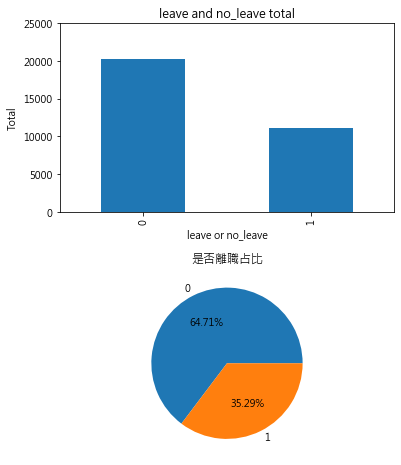

In [3]:
import imblearn
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score,roc_auc_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn import ensemble, preprocessing, metrics
#from imblearn.over_sampling import BorderlineSMOTE
#from imblearn.under_sampling import TomekLinks
from sklearn.datasets import make_classification
import seaborn as sns
from sklearn.metrics import roc_curve, auc 
import warnings

warnings.filterwarnings('ignore')

plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False



cols = ['年資','年齡','姓別代號','台成清交(最高)','理工科系(最高)','台成清交(次高)','理工科系(次高)','外語專長種類數','個人專長種類數','體育專長種類數'
       ,'婚姻代號','撫養人數','第三個月事假時數','第三個月病假時數','第三個月曠職時數','第三個月特休時數','第三個月遲到次數'
       ,'第三個月未帶卡次數','第三個月遺失卡次數','第三個月忘刷卡次數','第二個月事假時數','第二個月病假時數','第二個月曠職時數','第二個月特休時數','第二個月遲到次數'
       ,'第二個月未帶卡次數','第二個月遺失卡次數','第二個月忘刷卡次數','近一年考績']
x = train[cols]
y = train['是否離職']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1,shuffle=True)

#x_res,y_res = BorderlineSMOTE(kind='borderline-2').fit_resample(X_train,y_train)
#X_res, Y_res = TomekLinks().fit_resample(X_train, y_train)



count_class_0, count_class_1 = train.是否離職.value_counts()
#print('Class 0:', count_class_0)
#print('Class 1:', count_class_1)
df_class_0 = train[train['是否離職'] == 0]
df_class_1 = train[train['是否離職'] == 1]


##over-sampling
df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_test_over = pd.concat([df_class_0, df_class_1_over], axis=0)

#print('Random over-sampling:')
#print(train.是否離職.value_counts())

plt.figure(figsize=(6,8))
plt.subplot(2,1,1)
plt.ylim(0,25000)
plt.ylabel('Total')
plt.xlabel('leave or no_leave')
train.是否離職.value_counts().plot(kind='bar', title='leave and no_leave total');

plt.subplots_adjust(wspace =0, hspace =0.3)
plt.subplot(2,1,2)
plt.title("是否離職占比")
plt.pie(train.是否離職.value_counts(),labels=[0,1], autopct="%1.2f%%")
plt.savefig('fpc.jpg')
'''
##under-sampling
df_class_0_under = df_class_0.sample(count_class_1)
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_test_under.是否離職.value_counts())

df_test_under.是否離職.value_counts().plot(kind='bar', title='Count (是否離職)');


bag = ensemble.BaggingClassifier(n_estimators = 100)
bag_fit = bag.fit(X_train, y_train)
test_y_predicted = bag.predict(X_test)
accuracy = accuracy_score(y_test, test_y_predicted)
print('BaggingClassifier accuracy:',accuracy)


logi = LogisticRegression()
logi.fit(X_train,y_train)
result = logi.predict(X_test)

print('no_oversampling_roc_auc_score:',roc_auc_score(y_test,result))
fpr, tpr, _ = roc_curve(y_test,result)
plt.figure(figsize=(5, 5))
plt.axis([0, 1, 0, 1])
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.show()
'''
#result1 = confusion_matrix(y_test, result)
#print("Confusion Matrix:")
#print(result1)
#print(classification_report(y_test,result))
#print('Logistic regression accuracy: {:.3f}'.format(accuracy_score(y_test, logi.predict(X_test))))

#rfc = RandomForestClassifier()
#rfc.fit(X_train,y_train)
#print('RandomForestClassifier accuracy: {:.3f}'.format(accuracy_score(y_test, rfc.predict(X_test))))
'''''
'''''

In [23]:
import imblearn
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek
from sklearn.svm import SVC  
from sklearn.ensemble import RandomForestClassifier ,AdaBoostClassifier,GradientBoostingClassifier
#from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc ,recall_score,f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
import seaborn as sns
from sklearn.model_selection import cross_val_score,cross_val_predict



ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_sample(X_train, y_train)

#print(sorted(Counter(y_resampled).items()))

#X_resampled_smote, y_resampled_smote = SMOTE().fit_sample(X_train, y_train)
#print(sorted(Counter(y_resampled_smote).items()))

#X_resampled_adasyn, y_resampled_adasyn = ADASYN().fit_sample(X_train, y_train) 
#print(sorted(Counter(y_resampled_adasyn).items()))

#rus = RandomUnderSampler(random_state=0)
#X_resampled, y_resampled = rus.fit_sample(X_train, y_train) 
#print(sorted(Counter(y_resampled).items()))


#smote_enn = SMOTEENN(random_state=0)
#X_resampled, y_resampled = smote_enn.fit_sample(X_train, y_train)
#print(sorted(Counter(y_resampled).items()))


#smote_tomek = SMOTETomek(random_state=0)
#X_resampled, y_resampled = smote_tomek.fit_sample(X_train, y_train)
#print(sorted(Counter(y_resampled).items()))
#rfc = BernoulliNB()
#rfc.fit(X_resampled, y_resampled)
#preds = rfc.predict(X_test)
#print('BernoulliNB oversampling_roc_auc_score:',roc_auc_score(y_test,preds))
classifier = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=10),
    n_estimators=50
)

classifier_over = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=10),
    n_estimators=50
)


classifier.fit(X_train, y_train)
classifier_over.fit(X_resampled, y_resampled)
predictions = classifier.predict(X_test)
predictions_over = classifier_over.predict(X_test)
#print(predictions)


scores = cross_val_score(classifier,X_train, y_train, cv=5)
print('No oversample Train Accuracy:',scores.mean())
scores = cross_val_score(classifier,X_test, y_test, cv=5)
print('No oversample Test Accuracy:',scores.mean())
print(confusion_matrix(y_test, predictions))

scores = cross_val_score(classifier_over,X_resampled, y_resampled, cv=5)
print('oversample Train Accuracy:',scores.mean())
scores = cross_val_score(classifier_over,X_test, y_test, cv=5)
print('oversample Test Accuracy:',scores.mean())
print(confusion_matrix(y_test, predictions_over))

print('mo_roc_auc_score:',roc_auc_score(y_test,predictions))
print('mo_oversampling_roc_auc_score:',roc_auc_score(y_test,predictions_over))

#print(recall_score(y_test,predictions))
#print(f1_score(y_test,predictions))

'''
k_range = range(1, 10)
k_scores = []
for k in k_range:
   
    scores = cross_val_score(classifier, X_resampled, y_resampled, cv=10, scoring='accuracy')
    k_scores.append(scores.mean())
'''    
    
'''   
plt.subplot(3,1,1)
fpr, tpr, _ = roc_curve(y_test,predictions)
plt.axis([0, 1, 0, 1])
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

plt.subplot(3,1,2)
plt.plot(k_range,k_scores )
plt.xlabel('Value of K')
plt.ylabel('Cross-Validated Accuracy')
plt.show()

plt.subplot(3,1,3)
C2 = confusion_matrix(y_test, predictions)
sns.heatmap(C2,annot=True,fmt ='.0f')
'''


KeyboardInterrupt: 

In [ ]:
#測試將切分資料時正負比例均衡

In [213]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier ,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier    
from imblearn.over_sampling import SMOTE

train = pd.read_csv('./f_pre_model.csv',header=0)

pos_data = train[train['是否離職'] == 0].reindex()
train_pos_data = pos_data.iloc[:int(len(pos_data) * 0.7)].copy()
test_pos_data = pos_data.iloc[int(len(pos_data) * 0.7):].copy()


neg_data = train[train['是否離職'] == 1].reindex()
train_neg_data = neg_data.iloc[:int(len(neg_data) * 0.7)].copy()
test_neg_data = neg_data.iloc[int(len(neg_data) * 0.7):].copy()

train_data = pd.concat([train_pos_data,train_neg_data])
test_data = pd.concat([test_pos_data,test_neg_data])

print('訓練集樣本個數:',len(train_data))
print('正負樣本比例:',len(train_pos_data) / len(train_neg_data))

print('測試集樣本個數:',len(test_data))
print('正負樣本比例:',len(test_pos_data) / len(test_neg_data))

classifier = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=10),
    n_estimators=50
)
classifier1 = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=10),
    n_estimators=50
)

train_target = train_data['是否離職']
train_data.drop(['是否離職'],axis=1)

test_target = test_data['是否離職']
test_data.drop(['是否離職'],axis=1)

#classifier.fit(train_data,train_target)
print('CART決策樹:')

print('測試集中正樣本個數:',len(test_pos_data))
print('測試集中負樣本個數:',len(test_neg_data))




print('重採樣本前:')
print('正樣本個數:',len(train_target[train_target == 0]))
print('負樣本個數:',len(train_target[train_target == 1]))

classifier1.fit(train_data,train_target)
test_pred1 = classifier1.predict(test_data)
print(confusion_matrix(test_target, test_pred1,labels=[0,1]))
print('準確率',accuracy_score(test_target, test_pred1))

st = SMOTE(random_state=1)
train_resample,train_resample_target = st.fit_sample(train_data,train_target)

print('重採樣本後:')
print('正樣本個數:',len(train_resample_target[train_resample_target == 0]))
print('負樣本個數:',len(train_resample_target[train_resample_target == 1]))

classifier.fit(train_resample,train_resample_target)

test_pred = classifier.predict(test_data)
print(confusion_matrix(test_target, test_pred,labels=[0,1]))
#print('準確率',accuracy_score(test_target, test_pred))
print('mo_roc_auc_score:',roc_auc_score(test_target,test_pred1))

訓練集樣本個數: 1929
正負樣本比例: 18.29
測試集樣本個數: 827
正負樣本比例: 18.232558139534884
CART決策樹:
測試集中正樣本個數: 784
測試集中負樣本個數: 43
重採樣本前:
正樣本個數: 1829
負樣本個數: 100
[[784   0]
 [  0  43]]
準確率 1.0
重採樣本後:
正樣本個數: 1829
負樣本個數: 1829
[[784   0]
 [  0  43]]
mo_roc_auc_score: 1.0


In [ ]:
## rolling train model

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,roc_auc_score,f1_score
from sklearn.ensemble import RandomForestClassifier ,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier    
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler

train = pd.read_csv('./all_pre_model.csv',header=0)


windows = 3000 #for other
steps = 35
#windows = 1500 #for sa
#steps = 35

df = []

train = train.drop(['進企業日','離職日','第二個月忘刷卡次數','第三個月病假時數'
                    ,'第三個月曠職時數','第二個月遺失卡次數'
            ,'第三個月未帶卡次數','第三個月遺失卡次數','第二個月遲到次數','第二個月未帶卡次數','第三個月遲到次數'],axis=1)
#print(train)
cols = ['年資','年齡','姓別代號','台成清交(最高)','理工科系(最高)','台成清交(次高)','理工科系(次高)','外語專長種類數','個人專長種類數','體育專長種類數'
       ,'婚姻代號','撫養人數','第三個月事假時數','第三個月特休時數'
       ,'第三個月未帶卡次數','第三個月遺失卡次數','第三個月忘刷卡次數','第二個月事假時數','第二個月病假時數','第二個月特休時數'
       ,'第二個月忘刷卡次數','近一年考績','第三個月案件催辦次數','第二個月案件催辦次數'
       ,'第三個月評核分數','第二個月評核分數','是否離職']



classifier = AdaBoostClassifier(
    DecisionTreeClassifier(criterion='gini',class_weight='balanced',max_depth=10),
    n_estimators=50
)

st = RandomOverSampler(random_state=1)

data = np.arange(len(train))

def rolling(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

a = rolling(data,windows)
#print(a)

scores_roc = []
scores_accuracy = []
k = 0

for i in range(0,a.shape[0],windows): 
    for j in range(0,a.shape[1],1): #100

       df.append(train.iloc[a[i][j],:])
       #print(i,j,a[i][j])
       k = k + 1

       if k == windows:
            
            test_1=pd.DataFrame(columns=cols,data=df)
            
            x = test_1[cols]
            x = x.drop(['是否離職'],axis=1)
            x_train_pos_data = x.iloc[:int(len(x) * 0.7)].copy()        
            x_test_pos_data = x.iloc[int(len(x) * 0.7):].copy()
         
            
            y = test_1['是否離職']
            y_train_pos_data = y.iloc[:int(len(y) * 0.7)].copy()            
            y_test_pos_data = y.iloc[int(len(x) * 0.7):].copy()  
            
       
        
            train_resample,train_resample_target = st.fit_sample(x_train_pos_data,y_train_pos_data)
            classifier.fit(train_resample,train_resample_target)
            #classifier.fit(x_train_pos_data,y_train_pos_data)
            test_pred = classifier.predict(x_test_pos_data)
            
            try:
                scores_accuracy.append(accuracy_score(y_test_pos_data,test_pred))
            except ValueError:
                pass   
            
            try:
                scores_roc.append(roc_auc_score(y_test_pos_data,test_pred))
            except ValueError:
                pass       
            
            k = 0
            #df = []
   
            
     
       


C:\Users\mcut\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

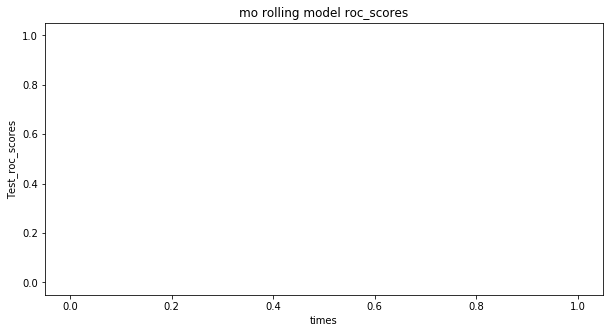

In [7]:
plt.figure(figsize=(10,5))
plt.title('mo rolling model roc_scores')
plt.xlabel('times')
plt.ylabel('Test_roc_scores')
plt.plot(scores_roc)
#plt.savefig('mo_roll')

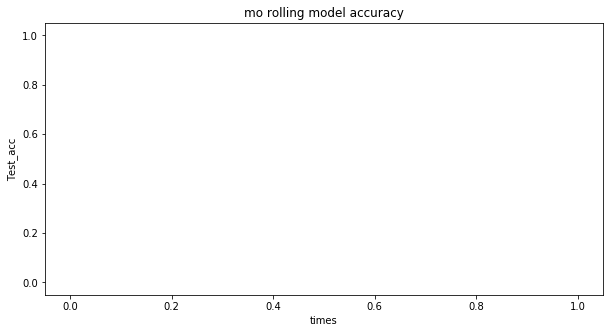

In [3]:
plt.figure(figsize=(10,5))
plt.title('mo rolling model accuracy')
plt.xlabel('times')
plt.ylabel('Test_acc')
plt.plot(scores_accuracy)
#plt.savefig('mo_roll_acc')

In [ ]:
##特徵重要性前五

In [27]:
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False

estimator = GradientBoostingClassifier()
estimator.fit(x.values,y)


plt.figure(figsize=(10,8))

feat = pd.Series(data=estimator.feature_importances_,index=x.columns)
feat = feat.sort_values(ascending=False)


#feat.plot(kind='bar', title='Features select (mo)');
print(feat)


年資            0.757834
年齡            0.223138
婚姻代號          0.005018
姓別代號          0.003002
第二個月評核分數      0.002643
體育專長種類數       0.002357
第二個月特休時數      0.001666
第三個月特休時數      0.001111
理工科系(次高)      0.001046
第二個月事假時數      0.000756
理工科系(最高)      0.000695
近一年考績         0.000229
第三個月評核分數      0.000149
第二個月病假時數      0.000098
撫養人數          0.000070
台成清交(次高)      0.000055
第二個月曠職時數      0.000047
第二個月案件催辦次數    0.000020
第三個月忘刷卡次數     0.000019
第三個月案件催辦次數    0.000012
外語專長種類數       0.000011
台成清交(最高)      0.000010
個人專長種類數       0.000008
第三個月事假時數      0.000004
第二個月忘刷卡次數     0.000000
第三個月病假時數      0.000000
第二個月遺失卡次數     0.000000
第三個月曠職時數      0.000000
第三個月未帶卡次數     0.000000
第三個月遺失卡次數     0.000000
第二個月遲到次數      0.000000
第二個月未帶卡次數     0.000000
第三個月遲到次數      0.000000
dtype: float64


<Figure size 720x576 with 0 Axes>

In [ ]:
##Adaboost

In [58]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_breast_cancer
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

classifier = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=10),
    n_estimators=50
)

classifier.fit(X_resampled, y_resampled)
predictions = classifier.predict(X_test)
#print(predictions)
#print('oversampling_roc_auc_score:',roc_auc_score(y_test,predictions))
confusion_matrix(y_test, predictions)

array([[1190,   93],
       [  40,    7]], dtype=int64)

In [ ]:
#NN version

In [175]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
import numpy as np
from keras.layers import Dense, Dropout, BatchNormalization, Activation


early_stopping_monitor = EarlyStopping(patience=3)

cols = ['是否離職','進企業日','出生日期','姓別代號','姓別名稱','認定學歷代號','台成清交(最高)','理工科系(最高)','外語專長種類數'
       ,'婚姻代號','撫養人數','近一個月事假時數','近一個月病假時數','近一個月曠職時數','近一個月特休時數','近一個月遲到次數'
       ,'近一個月未帶卡次數','近一個月遺失卡次數','近一個月忘刷卡次數','近一年考績']
x = train[cols]

x_array = x.values
Label = x_array[:,0]  
Features = x_array[:,1:]  

ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_sample(Features, Label)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=0)
n_cols = x.shape[1]


model = Sequential()
#input layer
model.add(Dense(8, input_shape=(19,)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.4))

# hidden layers
model.add(Dense(8))
model.add(BatchNormalization())
model.add(Activation("sigmoid"))
model.add(Dropout(0.4))
    
model.add(Dense(4))
model.add(BatchNormalization())
model.add(Activation("sigmoid"))
model.add(Dropout(0.4))
    
model.add(Dense(2, activation="sigmoid"))
    
# output layer
model.add(Dense(1, activation='linear'))
model.summary()

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_resampled, y_resampled, validation_split=0.3, nb_epoch=100, batch_size=30)

#plt.plot(history.history['acc'])
#plt.plot(history.history['val_acc'])
#plt.title('model accuracy')
#plt.ylabel('accuracy')
#plt.xlabel('epoch')
#plt.legend(['train', 'test'], loc='upper left') 
#plt.show()
# summarize history for loss plt.plot(history.history['loss']) plt.plot(history.history['val_loss']) plt.title('model loss')
#plt.ylabel('loss')
#plt.xlabel('epoch')
#plt.legend(['train', 'test'], loc='upper left') 
#plt.show()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_424 (Dense)            (None, 8)                 160       
_________________________________________________________________
batch_normalization_64 (Batc (None, 8)                 32        
_________________________________________________________________
activation_64 (Activation)   (None, 8)                 0         
_________________________________________________________________
dropout_64 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_425 (Dense)            (None, 8)                 72        
_________________________________________________________________
batch_normalization_65 (Batc (None, 8)                 32        
_________________________________________________________________
activation_65 (Activation)   (None, 8)                 0         
__________

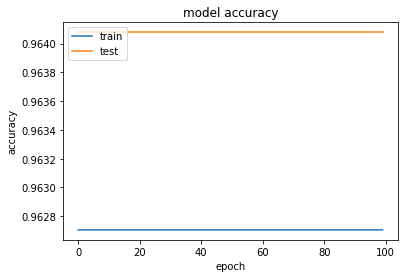

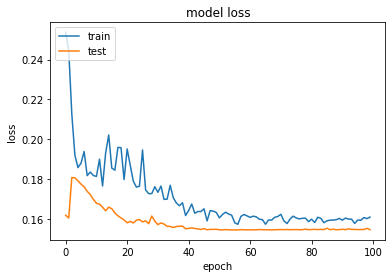

In [153]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left') 
plt.savefig('NNc')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('NNl')
plt.show()



In [4]:
from tpot import TPOTClassifier
from sklearn.model_selection import train_test_split

cols = ['進企業日','出生日期','姓別代號','姓別名稱','認定學歷代號','台成清交(最高)','理工科系(最高)','外語專長種類數'
       ,'婚姻代號','撫養人數','近一個月事假時數','近一個月病假時數','近一個月曠職時數','近一個月特休時數','近一個月遲到次數'
       ,'近一個月未帶卡次數','近一個月遺失卡次數','近一個月忘刷卡次數','近一年考績']
x = train[cols]
y = train['是否離職']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=0)


tpot = TPOTClassifier(verbosity=2, max_time_mins=2, max_eval_time_mins=0.04, population_size=40)
tpot.fit(X_train, y_train)

Generation 1 - Current best internal CV score: 0.9628783282777217
Generation 2 - Current best internal CV score: 0.9628783282777217
Generation 3 - Current best internal CV score: 0.9628783282777217
Generation 4 - Current best internal CV score: 0.9628783282777217
Generation 5 - Current best internal CV score: 0.9628783282777217

2.0075195833333335 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: RandomForestClassifier(input_matrix, bootstrap=False, criterion=entropy, max_features=0.3, min_samples_leaf=6, min_samples_split=6, n_estimators=100)


TPOTClassifier(config_dict=None, crossover_rate=0.1, cv=5,
               disable_update_check=False, early_stop=None, generations=1000000,
               max_eval_time_mins=0.04, max_time_mins=2, memory=None,
               mutation_rate=0.9, n_jobs=1, offspring_size=None,
               periodic_checkpoint_folder=None, population_size=40,
               random_state=None, scoring=None, subsample=1.0, template=None,
               use_dask=False, verbosity=2, warm_start=False)

In [30]:
tpot.score(X_test,y_test)

0.9634782608695652

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


df = pd.read_excel('./turnover/personalinformation_total.xlsx',header=0)
df1 = pd.read_excel('./turnover/resign.xls',header=0)

df1 = df1.drop(['離職代號','辭職原因大類','辭職原因大類名稱','辭職原因中類','辭職原因中類名稱','辭職原因說明'],axis=1)

res = pd.merge(df,df1,how='left', on='識別碼') 
res.to_csv('./基本資料+離職.csv',index=False)
res

,,識別碼,進企業日,出生日期,姓別代號,姓別名稱,實際學歷代號,實際學歷名稱,認定學歷代號,認定學歷名稱,...,理工科系(次高),外語專長種類數,個人專長種類數,體育專長種類數,企業外工作年資,婚姻代號,婚姻名稱,撫養人數,離職日,離職名稱
0,1,AAB/5xAAKAAABP0AAA,850606,480808,M,男,C,學士,C,學士,...,NaN,0,0,0,NaN,M,已婚,1,NaN,NaN
1,2,AAB/5xAAKAAABP0AAC,850916,561027,M,男,C,學士,C,學士,...,NaN,0,0,0,1年11月4日,M,已婚,1,NaN,NaN
2,3,AAB/5xAAKAAABP0AAD,841102,551224,M,男,C,學士,C,學士,...,NaN,0,0,0,NaN,M,已婚,0,870505.0,辭職
3,4,AAB/5xAAKAAABP0AAE,850606,590321,M,男,C,學士,C,學士,...,NaN,0,0,0,NaN,M,已婚,3,NaN,NaN
4,5,AAB/5xAAKAAABP0AAF,790222,530807,M,男,J,高工,J,高工,...,NaN,0,0,0,NaN,S,單身,0,840602.0,辭職
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110551,110539,AAB/5xABlAAATTQAAG,1080812,850321,F,女,C,學士,H,高中,...,NaN,0,0,0,NaN,S,單身,0,NaN,NaN
110552,110540,AAB/5xABlAAATTQAAH,1080812,870723,F,女,F,公立二專,H,高中,...,NaN,0,0,0,NaN,S,單身,0,NaN,NaN
110553,110541,AAB/5xABlAAATTQAAI,1080812,840103,F,女,C,學士,H,高中,...,NaN,0,0,0,NaN,S,單身,0,NaN,NaN
110554,110542,AAB/5xABlAAATTQAAJ,1080812,781018,F,女,H,高中,M,國、初中,...,NaN,0,0,0,NaN,M,已婚,0,NaN,NaN


In [11]:
df = pd.read_csv('./基本資料+離職.csv',header=0)
df1 = pd.read_csv('./leaverecord_result_three.csv',header=0)

#df1 = df1.drop(['離職代號','辭職原因大類','辭職原因大類名稱','辭職原因中類','辭職原因中類名稱','辭職原因說明'],axis=1)

res1 = pd.merge(df,df1,how='left', on='識別碼') 
res1.to_csv('./基本資料+離職+出勤.csv',index=False)
res1

,,識別碼,進企業日,出生日期,姓別代號,姓別名稱,實際學歷代號,實際學歷名稱,認定學歷代號,認定學歷名稱,...,第三個月忘刷卡次數,年月.1,第二個月事假時數,第二個月病假時數,第二個月曠職時數,第二個月特休時數,第二個月遲到次數,第二個月未帶卡次數,第二個月遺失卡次數,第二個月忘刷卡次數
0,1,AAB/5xAAKAAABP0AAA,850606,480808,M,男,C,學士,C,學士,...,0.0,10807.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0
1,2,AAB/5xAAKAAABP0AAC,850916,561027,M,男,C,學士,C,學士,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,AAB/5xAAKAAABP0AAD,841102,551224,M,男,C,學士,C,學士,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,AAB/5xAAKAAABP0AAE,850606,590321,M,男,C,學士,C,學士,...,0.0,10804.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,AAB/5xAAKAAABP0AAF,790222,530807,M,男,J,高工,J,高工,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110551,110539,AAB/5xABlAAATTQAAG,1080812,850321,F,女,C,學士,H,高中,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110552,110540,AAB/5xABlAAATTQAAH,1080812,870723,F,女,F,公立二專,H,高中,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110553,110541,AAB/5xABlAAATTQAAI,1080812,840103,F,女,C,學士,H,高中,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110554,110542,AAB/5xABlAAATTQAAJ,1080812,781018,F,女,H,高中,M,國、初中,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
df = pd.read_csv('./基本資料+離職+出勤.csv',header=0)
df1 = pd.read_csv('./result_.csv',header=0)

#df1 = df1.drop(['離職代號','辭職原因大類','辭職原因大類名稱','辭職原因中類','辭職原因中類名稱','辭職原因說明'],axis=1)

res2 = pd.merge(df,df1,how='left', on='識別碼') 
res2.to_csv('./基本資料+離職+出勤+催辦.csv',index=False)
res2

,,識別碼,進企業日,出生日期,姓別代號,姓別名稱,實際學歷代號,實際學歷名稱,認定學歷代號,認定學歷名稱,...,第二個月曠職時數,第二個月特休時數,第二個月遲到次數,第二個月未帶卡次數,第二個月遺失卡次數,第二個月忘刷卡次數,年月_y,第三個月案件催辦次數,年月.1_y,第二個月案件催辦次數
0,1,AAB/5xAAKAAABP0AAA,850606,480808,M,男,C,學士,C,學士,...,0.0,5.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
1,2,AAB/5xAAKAAABP0AAC,850916,561027,M,男,C,學士,C,學士,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,AAB/5xAAKAAABP0AAD,841102,551224,M,男,C,學士,C,學士,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,AAB/5xAAKAAABP0AAE,850606,590321,M,男,C,學士,C,學士,...,0.0,0.0,0.0,0.0,0.0,0.0,9510.0,0.0,9511.0,0.0
4,5,AAB/5xAAKAAABP0AAF,790222,530807,M,男,J,高工,J,高工,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110551,110539,AAB/5xABlAAATTQAAG,1080812,850321,F,女,C,學士,H,高中,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110552,110540,AAB/5xABlAAATTQAAH,1080812,870723,F,女,F,公立二專,H,高中,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110553,110541,AAB/5xABlAAATTQAAI,1080812,840103,F,女,C,學士,H,高中,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110554,110542,AAB/5xABlAAATTQAAJ,1080812,781018,F,女,H,高中,M,國、初中,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
df = pd.read_csv('./基本資料+離職+出勤+催辦.csv',header=0)
df1 = pd.read_csv('./result1_.csv',header=0)
df1.drop_duplicates(['識別碼'],keep='last', inplace=True)

#df1 = df1.drop(['離職代號','辭職原因大類','辭職原因大類名稱','辭職原因中類','辭職原因中類名稱','辭職原因說明'],axis=1)

res3 = pd.merge(df,df1,how='left', on='識別碼') 
#res3.to_csv('./基本資料+離職+出勤+催辦+月評.csv',index=False)
res3

,,識別碼,進企業日,出生日期,姓別代號,姓別名稱,實際學歷代號,實際學歷名稱,認定學歷代號,認定學歷名稱,...,第二個月遺失卡次數,第二個月忘刷卡次數,年月_y_x,第三個月案件催辦次數,年月.1_y,第二個月案件催辦次數,年月_x_y,第三個月評核分數,年月_y_y,第二個月評核分數
0,1,AAB/5xAAKAAABP0AAA,850606,480808,M,男,C,學士,C,學士,...,0.0,0.0,NaN,NaN,NaN,NaN,10807,88.0,10808,91.0
1,2,AAB/5xAAKAAABP0AAC,850916,561027,M,男,C,學士,C,學士,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,AAB/5xAAKAAABP0AAD,841102,551224,M,男,C,學士,C,學士,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,AAB/5xAAKAAABP0AAE,850606,590321,M,男,C,學士,C,學士,...,0.0,0.0,9510.0,0.0,9511.0,0.0,10712,89.0,10803,91.0
4,5,AAB/5xAAKAAABP0AAF,790222,530807,M,男,J,高工,J,高工,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110551,110539,AAB/5xABlAAATTQAAG,1080812,850321,F,女,C,學士,H,高中,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110552,110540,AAB/5xABlAAATTQAAH,1080812,870723,F,女,F,公立二專,H,高中,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110553,110541,AAB/5xABlAAATTQAAI,1080812,840103,F,女,C,學士,H,高中,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110554,110542,AAB/5xABlAAATTQAAJ,1080812,781018,F,女,H,高中,M,國、初中,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



df = pd.read_csv('./turnover/performanceappraisal_all.csv',header=0)

df.drop_duplicates(['識別碼'],keep='last', inplace=True)

#df = df.drop(['年度','生效日'],axis=1)

res1 = pd.merge(res3,df,how='left', on='識別碼') 


res1.to_csv('./基本資料+離職+出勤+催辦+月評+考績.csv',index=False)

In [10]:
import pandas as pd
df = pd.read_csv('./基本資料+離職+出勤+催辦+月評.csv',header=0)

df['離職日'] = df['離職日'].fillna('1080831') 
#df.head(10)

df.to_csv('./基本資料+離職+出勤+催辦+月評2.csv',index=False)

In [70]:
new_pred = classifier.predict(sc.transform(np.array([[0,25,0,1,0,1,0,0,0,0,2,3,0,0,0,0,0,0,0,0,0,0,0,9]])))
#new_pred = (new_pred > 0.5)
new_pred

array([[0.95726925]], dtype=float32)

In [73]:
## MLP

In [23]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import backend as K
import tensorflow as tf
from focal_loss import BinaryFocalLoss
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import keras
from keras.models import Sequential
from keras.layers import Dense,Activation,Dropout
#from imblearn.over_sampling import RandomOverSampler
from keras import regularizers
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from keras.utils.generic_utils import get_custom_objects



def binary_focal_loss(gamma=5, alpha=0.3):
    """
    Binary form of focal loss.
    適用於二分類問題的focal loss
    
    focal_loss(p_t) = -alpha_t * (1 - p_t)**gamma * log(p_t)
        where p = sigmoid(x), p_t = p or 1 - p depending on if the label is 1 or 0, respectively.
    References:
        https://arxiv.org/pdf/1708.02002.pdf
    Usage:
     model.compile(loss=[binary_focal_loss(alpha=.25, gamma=2)], metrics=["accuracy"], optimizer=adam)
    """
    alpha = tf.constant(alpha, dtype=tf.float32)
    gamma = tf.constant(gamma, dtype=tf.float32)
    
    def binary_focal_loss_fixed(y_true, y_pred):
        """
        y_true shape need be (None,1)
        y_pred need be compute after sigmoid
        """
        
        y_true = tf.cast(y_true, tf.float32)
        
        alpha_t = y_true*alpha + (K.ones_like(y_true)-y_true)*(1-alpha)
    
        p_t = y_true*y_pred + (K.ones_like(y_true)-y_true)*(K.ones_like(y_true)-y_pred) + K.epsilon()
        focal_loss = - alpha_t * K.pow((K.ones_like(y_true)-p_t),gamma) * K.log(p_t)
        
        return K.mean(focal_loss)
    return binary_focal_loss_fixed

get_custom_objects().update({'focal_loss':binary_focal_loss()})


#st = RandomOverSampler(random_state=1)
sc = StandardScaler()
    
df = pd.read_csv('./all_pre_model_2.csv',header=0)

df = df.drop(['離職日','外語專長種類數','第二個月忘刷卡次數','第三個月病假時數','體育專長種類數'
              ,'個人專長種類數','第三個月曠職時數','第二個月遺失卡次數'
            ,'第三個月未帶卡次數','第三個月遺失卡次數','第二個月遲到次數','第二個月未帶卡次數'
            ,'第三個月遲到次數'],axis=1)

cols = ['年資','是否離職','年齡','姓別代號','台成清交(最高)','理工科系(最高)','台成清交(次高)',
        '理工科系(次高)','婚姻代號','撫養人數','第三個月事假時數',
        '第三個月特休時數','第三個月忘刷卡次數','第二個月事假時數','第二個月病假時數','第二個月曠職時數',
        '第二個月特休時數','近一年考績']




#x = df.drop(['是否離職'],axis = 1).values
#y = df['是否離職'].values



df2 = []
cv_accuracies = []
steps = []

#X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
#windows = 50000
#steps = 1000
#data = np.arange(len(df))
#print(data)

'''
def rolling(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

a = rolling(data,windows)
print(a.shape)
'''
#scores_roc = []
#scores_accuracy = []
m = 0

df['進企業日'] = (df['進企業日'] + 19110000)
temp = []
count = 0
day = df['進企業日']

for i in range(0,len(day)):
    aaa = str(day.iloc[i])
    string = aaa
    temp.append(string[4:6])
    print(temp)  

#print(len(temp))
for j in range(0,len(temp)-1,1):
    
    if (temp[j] == temp[j+1]):
        count = count + 1
    else:
        steps.append(count)
        count = 0
        #print(steps)
        #break
print(steps)


clf = Sequential()
clf.add(Dense(48, input_dim=17,kernel_regularizer=regularizers.l1_l2(l1=0.002,l2=0.002)))
clf.add(Activation('relu'))
clf.add(Dropout(0.3))
clf.add(Dense(24,kernel_regularizer=regularizers.l1_l2(l1=0.002,l2=0.002)))
clf.add(Activation('relu'))
clf.add(Dropout(0.3))
clf.add(Dense(1))
clf.add(Activation('sigmoid'))
clf.compile(optimizer='adam',loss=['focal_loss'],metrics=['accuracy'])

 

step = 0    
q = steps[0]
p = -1
z = 0
w = 7
sum_p = []
sum_ten = 0
temp1 = []
year = 5

for v in range(0,year,1):
    temp1.append(steps[v])
    sum_ten = sum(temp1)
#print(sum_ten)

for x in range(0,1,1): #10 years
    #print(steps[x])
    for o in range(p+1,sum_ten+1,1):
       #print((p+1,q+1))
       df2.append(df.iloc[o,:])
       #print(p+o)
       m = m + 1
    
       if m == (sum_ten - p):
            #print(1111)     
        
            test_1=pd.DataFrame(columns=cols,data=df2)
            #print(test_1.shape)
            
            x = test_1.drop(['是否離職'],axis = 1).values
            
            y = test_1['是否離職'].values
            
            X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
            '''
            x = test_1[cols]
            x = x.drop(['是否離職'],axis=1)
            x_train_pos_data = x.iloc[:int(len(x) * 0.7)].copy()   
            x_train_pos_data = x_train_pos_data.values
            x_test_pos_data = x.iloc[int(len(x) * 0.7):].copy()
            x_test_pos_data = x_test_pos_data.values
            
            
            y = test_1['是否離職']
            y_train_pos_data = y.iloc[:int(len(y) * 0.7)].copy()    
            y_train_pos_data = y_train_pos_data.values
            y_test_pos_data = y.iloc[int(len(x) * 0.7):].copy()  
            y_test_pos_data = y_test_pos_data.values
            '''
            #train_resample,train_resample_target = st.fit_sample(X_train,y_train)
           
            X_train = sc.fit_transform(X_train)
            X_test = sc.fit_transform(X_test)

            
            #clf.summary()
            #clf.compile(optimizer='adam',loss=[binary_focal_loss(alpha=.25, gamma=2)],metrics=['accuracy'])
            history = clf.fit(X_train, y_train, epochs = 10,verbose=0)            
            cost, accuracy = clf.evaluate(X_test, y_test, batch_size=y_test.shape[0], verbose=False)
            #y_pred = clf.predict_classes(X_test)
            cv_accuracies.append(accuracy)
            print('test cost:', cost, 'test accuracy:', accuracy)
            m = 0 


q = sum_ten + steps[year]

for x in range(year,len(steps)+1,1): #every 1 year
    #print(steps[x])
    for o in range(sum_ten+1,q+1,1):
       #print((p+1,q+1))
       df2.append(df.iloc[o,:])
       #print(p+o)
       m = m + 1
    
       if m == (q - sum_ten):
            #print(1111)     
        
            test_1=pd.DataFrame(columns=cols,data=df2)
            #print(test_1.shape)
            
            x = test_1.drop(['是否離職'],axis = 1).values
            
            y = test_1['是否離職'].values
            
            X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
            '''
            x = test_1[cols]
            x = x.drop(['是否離職'],axis=1)
            x_train_pos_data = x.iloc[:int(len(x) * 0.7)].copy()   
            x_train_pos_data = x_train_pos_data.values
            x_test_pos_data = x.iloc[int(len(x) * 0.7):].copy()
            x_test_pos_data = x_test_pos_data.values
            
            
            y = test_1['是否離職']
            y_train_pos_data = y.iloc[:int(len(y) * 0.7)].copy()    
            y_train_pos_data = y_train_pos_data.values
            y_test_pos_data = y.iloc[int(len(x) * 0.7):].copy()  
            y_test_pos_data = y_test_pos_data.values
            '''
            #train_resample,train_resample_target = st.fit_sample(X_train,y_train)
           
            X_train = sc.fit_transform(X_train)
            X_test = sc.fit_transform(X_test)

            
            #clf.summary()
            #clf.compile(optimizer='adam',loss=[binary_focal_loss(alpha=.25, gamma=2)],metrics=['accuracy'])
            history = clf.fit(X_train, y_train, epochs = 10,verbose=0)           
            cost, accuracy = clf.evaluate(X_test, y_test, batch_size=y_test.shape[0], verbose=False)
            #y_pred = clf.predict_classes(X_test)
            cv_accuracies.append(accuracy)
            print('test cost:', cost, 'test accuracy:', accuracy)
            #step = steps
            #print(step)
            m = 0 
            #if p == -1:
                
                #p = p + steps[z] + 1
            #else:
            #sum_ten = sum_ten + steps[z]
            
            if w != 18:
                for z in range(0,w,1):
                    sum_p.append(steps[z])
                    #print(sum_p)
                    q = sum(sum_p)
                                    
            sum_p = []
            #print(q)
            
            if w != 18:
                w = w + 1
                
            #print(w)
                #z = z + 1
            
            #for k in range(steps+step+1,len(temp)-1,1):
        
             #   if (temp[k] == temp[k+1]):
            
              #      count = count + 1
            
               # else:
                 #   step = steps + step  
                #    steps = count
                 #   count = 0
                    #print(steps,step)            
                 #   continue 
          
            
            


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



test cost: 0.4030808210372925 test accuracy: 0.6929134130477905
test cost: 0.1734163910150528 test accuracy: 0.6232876777648926
test cost: 0.048711150884628296 test accuracy: 0.6612021923065186
test cost: 0.019516998901963234 test accuracy: 0.6332046389579773
test cost: 0.011109324172139168 test accuracy: 0.65625
test cost: 0.009701880626380444 test accuracy: 0.6607539057731628
test cost: 0.009241646155714989 test accuracy: 0.6774193644523621
test cost: 0.009623861871659756 test accuracy: 0.6356821656227112
test cost: 0.0095414062961936 test accuracy: 0.648101270198822
test cost: 0.009723477065563202 test accuracy: 0.6300326585769653
test cost: 0.009438990615308285 test accuracy: 0.6586715579032898
test cost: 0.009598419070243835 test accuracy: 0.6398104429244995
test cost: 0.00969719048589468 test accuracy: 0.626719057559967
test cost: 0.009589399211108685 test accuracy: 0.6435366272926331
test cost: 0.00962976086884737 test accuracy: 0.63818359375
test cost: 0.009640882723033428 test

test cost: 0.009931174106895924 test accuracy: 0.5915994048118591
test cost: 0.009915836155414581 test accuracy: 0.5913004875183105
test cost: 0.00991771835833788 test accuracy: 0.5931364893913269
test cost: 0.009906251914799213 test accuracy: 0.5964243412017822
test cost: 0.009912550449371338 test accuracy: 0.5947169065475464
test cost: 0.009917010553181171 test accuracy: 0.5934059023857117
test cost: 0.009925025515258312 test accuracy: 0.5896567702293396
test cost: 0.009921845048666 test accuracy: 0.5937944650650024
test cost: 0.009914490394294262 test accuracy: 0.595026433467865
test cost: 0.009890586137771606 test accuracy: 0.596733808517456
test cost: 0.009924525395035744 test accuracy: 0.5900757312774658
test cost: 0.009931623935699463 test accuracy: 0.5918654799461365
test cost: 0.00993435736745596 test accuracy: 0.5914028882980347
test cost: 0.00992012768983841 test accuracy: 0.590467631816864
test cost: 0.009914535097777843 test accuracy: 0.5927477478981018
test cost: 0.009902

In [25]:
df['是否離職'].value_counts()

0    55924
1    37785
Name: 是否離職, dtype: int64

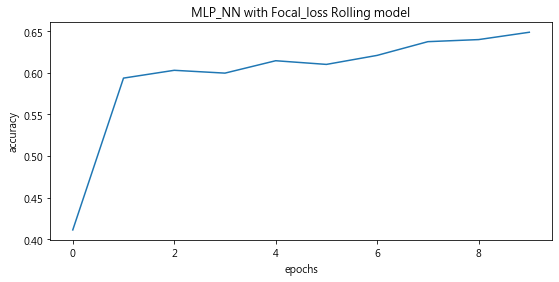

In [8]:
plt.figure(figsize=(9,4))
plt.title('MLP_NN with Focal_loss Rolling model')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.plot(cv_accuracies)
plt.savefig('NNct')

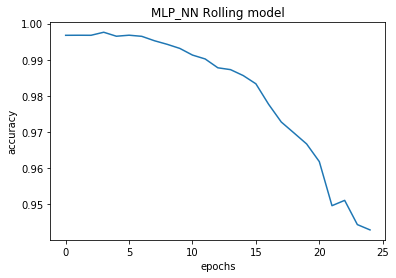

In [8]:
plt.title('MLP_NN Rolling model')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.plot(cv_accuracies)
#plt.savefig('NNct')

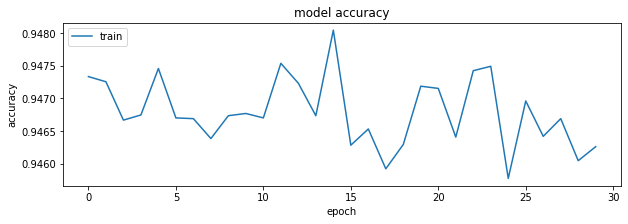

In [73]:
plt.figure(figsize=(10,3))
plt.plot(history.history['acc'])
#plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left') 
plt.savefig('NNc')
plt.show()

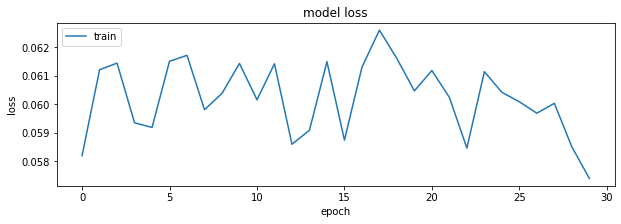

In [46]:
plt.figure(figsize=(10,3))
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left') 
#plt.savefig('NNcl')
plt.show()

In [ ]:
## RNN

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import keras
from keras.models import Sequential
from keras.layers import Dense,Activation,Dropout,SimpleRNN,Flatten
from imblearn.over_sampling import RandomOverSampler
from keras.layers.recurrent import LSTM
from keras import regularizers
from keras.utils.np_utils import *
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

st = RandomOverSampler(random_state=1)
sc = StandardScaler()
    
df = pd.read_csv('./all_pre_model.csv',header=0)

df = df.drop(['進企業日','離職日','第二個月忘刷卡次數','第三個月病假時數'
                    ,'第三個月曠職時數','第二個月遺失卡次數'
            ,'第三個月未帶卡次數','第三個月遺失卡次數','第二個月遲到次數','第二個月未帶卡次數','第三個月遲到次數'],axis=1)

cols = ['年資','是否離職','年齡','姓別代號','台成清交(最高)','理工科系(最高)','台成清交(次高)','理工科系(次高)',
        '外語專長種類數','個人專長種類數','體育專長種類數','婚姻代號','撫養人數','第三個月事假時數',
        '第三個月特休時數','第三個月忘刷卡次數','第二個月事假時數','第二個月病假時數','第二個月曠職時數',
        '第二個月特休時數','第三個月案件催辦次數','第二個月案件催辦次數','第三個月評核分數','第二個月評核分數',
        '近一年考績']


#x = df.drop(['是否離職'],axis = 1).values
#y = df['是否離職'].values

df2 = []
cv_accuracies = []

#X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
windows = 50000
steps = 1000
data = np.arange(len(df))
#print(data)



def rolling(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

a = rolling(data,windows)
print(a.shape)

#scores_roc = []
#scores_accuracy = []
k = 0
data_dim = 24 
timesteps = 1000

clf = Sequential()


for i in range(0,1,windows): 
    for j in range(0,a.shape[1],1): #2000

       df2.append(df.iloc[a[i][j],:])
       
       k = k + 1
        
       if k == windows:
            
        
            test_1=pd.DataFrame(columns=cols,data=df2)
            #print(test_1.shape)
            
            x = test_1.drop(['是否離職'],axis = 1).values
            
            y = test_1['是否離職'].values
            
            X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
            X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
            X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)
            #X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
            #X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

            #y_train = np_utils.to_categorical(y_train, num_classes=2)
            #y_test = np_utils.to_categorical(y_test, num_classes=2)
            '''
            x = test_1[cols]
            x = x.drop(['是否離職'],axis=1)
            x_train_pos_data = x.iloc[:int(len(x) * 0.7)].copy()   
            x_train_pos_data = x_train_pos_data.values
            x_test_pos_data = x.iloc[int(len(x) * 0.7):].copy()
            x_test_pos_data = x_test_pos_data.values
            
            
            y = test_1['是否離職']
            y_train_pos_data = y.iloc[:int(len(y) * 0.7)].copy()    
            y_train_pos_data = y_train_pos_data.values
            y_test_pos_data = y.iloc[int(len(x) * 0.7):].copy()  
            y_test_pos_data = y_test_pos_data.values
            '''
            #train_resample,train_resample_target = st.fit_sample(X_train,y_train)
           
            #X_train = sc.fit_transform(train_resample)
            #X_test = sc.fit_transform(X_test)
            
            
            clf.add(SimpleRNN(units = 10,input_shape=(1,timesteps),dropout=0.2))
            clf.add(Dense(2))          
            clf.add(Activation('sigmoid'))
            clf.summary()
            clf.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])


            
            history = clf.fit(X_train,y_train, epochs = 30,verbose=0)
            cost, accuracy = clf.evaluate(X_test, y_test, batch_size=y_test.shape[0], verbose=False)
           
            cv_accuracies.append(accuracy)
            print('test cost:', cost, 'test accuracy:', accuracy)
            k = 0
            
            
for p in range(windows,len(df),steps): #2000
    print(p)
    for o in range(0,steps,1):
       
       df2.append(df.iloc[p+o,:])
       
       k = k + 1
        
       if k == steps:
            
        
            test_1=pd.DataFrame(columns=cols,data=df2)
            #print(test_1.shape)
            
            x = test_1.drop(['是否離職'],axis = 1).values
            
            y = test_1['是否離職'].values
            
            X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
            X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
            X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
            '''
            x = test_1[cols]
            x = x.drop(['是否離職'],axis=1)
            x_train_pos_data = x.iloc[:int(len(x) * 0.7)].copy()   
            x_train_pos_data = x_train_pos_data.values
            x_test_pos_data = x.iloc[int(len(x) * 0.7):].copy()
            x_test_pos_data = x_test_pos_data.values
            
            
            y = test_1['是否離職']
            y_train_pos_data = y.iloc[:int(len(y) * 0.7)].copy()    
            y_train_pos_data = y_train_pos_data.values
            y_test_pos_data = y.iloc[int(len(x) * 0.7):].copy()  
            y_test_pos_data = y_test_pos_data.values
            '''
            #train_resample,train_resample_target = st.fit_sample(X_train,y_train)
           
            #X_train = sc.fit_transform(train_resample)
            #X_test = sc.fit_transform(X_test)

            
            #clf.summary()
            
            history = clf.fit(X_train,y_train, epochs = 30,verbose=0)
            cost, accuracy = clf.evaluate(X_test, y_test, batch_size=y_test.shape[0], verbose=False)
            
            cv_accuracies.append(accuracy)
            print('test cost:', cost, 'test accuracy:', accuracy)
            k = 0 

(60556, 50000)


ValueError: Input 0 is incompatible with layer simple_rnn_32: expected ndim=3, found ndim=4

In [2]:
from keras_explain.grad_cam import GradCam
import lime